# Import Libraries and Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import os
import seaborn as sb
import shutil
import soundfile as sf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

The **ESC-50 dataset** is a labeled collection of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification.

The dataset consists of 5-second-long recordings organized into 50 semantical classes (with 40 examples per class) loosely arranged into 5 major categories:

| <sub>Animals</sub> | <sub>Natural soundscapes & water sounds </sub> | <sub>Human, non-speech sounds</sub> | <sub>Interior/domestic sounds</sub> | <sub>Exterior/urban noises</sub> |
| :--- | :--- | :--- | :--- | :--- |
| <sub>Dog</sub> | <sub>Rain</sub> | <sub>Crying baby</sub> | <sub>Door knock</sub> | <sub>Helicopter</sub></sub> |
| <sub>Rooster</sub> | <sub>Sea waves</sub> | <sub>Sneezing</sub> | <sub>Mouse click</sub> | <sub>Chainsaw</sub> |
| <sub>Pig</sub> | <sub>Crackling fire</sub> | <sub>Clapping</sub> | <sub>Keyboard typing</sub> | <sub>Siren</sub> |
| <sub>Cow</sub> | <sub>Crickets</sub> | <sub>Breathing</sub> | <sub>Door, wood creaks</sub> | <sub>Car horn</sub> |
| <sub>Frog</sub> | <sub>Chirping birds</sub> | <sub>Coughing</sub> | <sub>Can opening</sub> | <sub>Engine</sub> |
| <sub>Cat</sub> | <sub>Water drops</sub> | <sub>Footsteps</sub> | <sub>Washing machine</sub> | <sub>Train</sub> |
| <sub>Hen</sub> | <sub>Wind</sub> | <sub>Laughing</sub> | <sub>Vacuum cleaner</sub> | <sub>Church bells</sub> |
| <sub>Insects (flying)</sub> | <sub>Pouring water</sub> | <sub>Brushing teeth</sub> | <sub>Clock alarm</sub> | <sub>Airplane</sub> |
| <sub>Sheep</sub> | <sub>Toilet flush</sub> | <sub>Snoring</sub> | <sub>Clock tick</sub> | <sub>Fireworks</sub> |
| <sub>Crow</sub> | <sub>Thunderstorm</sub> | <sub>Drinking, sipping</sub> | <sub>Glass breaking</sub> | <sub>Hand saw</sub> |

The dataset comes with a metadata file that labels each sound file with its relevant category.

In [2]:
metadata = pd.read_csv('ESC-50-master/meta/esc50.csv')

metadata.head()

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

Here, we remove unused colums. The only columns that matter is the category and the filename.

In [3]:
metadata = metadata[['category','filename']].copy()

metadata.head()

category           filename
0             dog   1-100032-A-0.wav
1  chirping_birds  1-100038-A-14.wav
2  vacuum_cleaner  1-100210-A-36.wav
3  vacuum_cleaner  1-100210-B-36.wav
4    thunderstorm  1-101296-A-19.wav

Here we can see the total size of the dataset and each unique value in the category column, corresponding to the different categories in the dataset.

In [4]:
print("Site of Dataset: " , metadata.shape)
metadata['category'].unique()


Site of Dataset:  (2000, 2)


array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

We need an array that stores all the animal cateogires so that we can filter the dataframe down to only animals.

In [5]:
animal_categories = [
    'dog',
    'chirping_birds',
    'crow','sheep',
    'frog',
    'cow',
    'insects',
    'hen',
    'pig',
    'rooster',
    'cat'
]

# Data Cleaning and preperation

We would need to prepare another folder called cleaned_audio. This folder will contain the processed audio files, preventing us from interacting or mutating the original audio files. In the code block below, we created a boolean flag that acts as a skip_delete. This means that if there already is a folder called cleaned_audio, It would not create the folder.

In [6]:
folder_path = 'cleaned_audio'
clean_data_file_path = 'cleaned_metadata.csv'
skip_delete = os.path.exists(clean_data_file_path)

# Check if the folder does not exist
if not os.path.exists(folder_path):
    # Create the folder
    os.makedirs(folder_path)
    result = f"Folder '{folder_path}' was created."
else:
    # If skip_delete is False, delete everything in the folder
    if not skip_delete:
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.pcleath.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                result = f'Failed to delete {file_path}. Reason: {e}'
        result = f"Existing contents of '{folder_path}' have been deleted."
    else:
        result = "Skipping deletion as per 'skip_delete' flag."

result



"Skipping deletion as per 'skip_delete' flag."

## Disassociating sound from the model
It is important to ensure that the model disassociates volume from the relevant animal categories. We don't know the extent of the dataset. It could be the case where all recordings of dogs are loud and all recordings of frogs are quiet. Hence we created 2 more duplicates of each audio file, one being 2x louder and one being 0.5x quieter in an effort to disassociate volume from the model.


In [7]:
source_directory = 'ESC-50-master/audio'

def adjust_volume(data, volume_change):
    return data * volume_change

if not skip_delete:
    for index, row in metadata.iterrows():
        filename = row['filename']
        category = row['category']

        #Copy original file over
        source_file = os.path.join(source_directory, filename)
        destination_file = os.path.join(folder_path, filename)
        shutil.copy2(source_file, destination_file)

        try:
            y, sr = librosa.load(source_file, sr=None)

            #Adjust volumes
            y_higher = adjust_volume(y,2)
            y_lower = adjust_volume(y,0.5)

            #Generate new filenames
            base, ext = os.path.splitext(filename)
            higher_volume_filename = f"{base}_higher{ext}"
            lower_volume_filename = f"{base}_lower{ext}"

            #Save the adjusted audio files
            higher_file_path = os.path.join(folder_path, higher_volume_filename)
            lower_file_path = os.path.join(folder_path, lower_volume_filename)
            sf.write(higher_file_path, y_higher, sr)
            sf.write(lower_file_path, y_lower, sr)

            # Add new entries to the dataframe
            new_rows = [
                {'category': category, 'filename': higher_volume_filename},
                {'category': category, 'filename': lower_volume_filename}
            ]
            metadata = pd.concat([metadata, pd.DataFrame(new_rows)], ignore_index=True)

        except Exception as e:
            print(f"Error processing file {filename}: {e}")

        result = "Files copied successfully."
else:
    result = "Skipping file copying and manipulation as per 'skip_delete' flag."

result

"Skipping file copying and manipulation as per 'skip_delete' flag."

We can see the new shape of the metadata below.

In [8]:
print("Site of Dataset: " , metadata.shape)

Site of Dataset:  (2000, 2)


# Feature Engineering
## How are we doing this?
The team has decided on using librosa for feature extraction. Here are the features we will be using, as defined in the `feature_names` array:

## 1. Mel-frequency Cepstral Coefficients (MFCCs)
- **Why?** MFCCs are very effective in capturing the timbral aspects of sound. They've been widely used in speech recognition and can differentiate various types of sounds including animal vocalizations. The coefficients effectively capture the rate changes in spectral bands and are useful for identifying different kinds of animal sounds. The first 13 features in the `feature_names` array correspond to the MFCCs.

## 2. Spectral Features
- **`Spectral_Centroid`:** Useful for identifying the "brightness" of a sound, which can differentiate between high-pitched and low-pitched animal calls.
- **`Spectral_Bandwidth`:** Provides information about the spread of the spectrum, which can help distinguish between broad and narrow-band sounds.
- **Spectral Contrast:** Useful for identifying different sound textures and can help differentiate between sounds in different environments or contexts. In the code, it is represented by the features `Low_Frequency_Contrast`, `Mid_Low_Frequency_Contrast`, `Mid_Frequency_Contrast`, `Mid_High_Frequency_Contrast`, `High_Frequency_Contrast`, `Very_High_Frequency_Contrast`, and `Extreme_High_Frequency_Contrast`.
- **`Spectral_Rolloff`:** Indicates the frequency below which a certain percentage of the total spectral energy is contained. It can be used to distinguish between harmonic (musical) and inharmonic sounds.

## 3. Chroma Features
- **Chroma STFT:** Captures the harmonic content of audio which might be useful for some species where the harmonic structure of the sound is important for classification. In the code, it is represented by the features `Chroma_C`, `Chroma_C#`, `Chroma_D`, `Chroma_D#`, `Chroma_E`, `Chroma_F`, `Chroma_F#`, `Chroma_G`, `Chroma_G#`, `Chroma_A`, `Chroma_A#`, and `Chroma_B`.

## 4. Zero-Crossing Rate (ZCR)
- **`Zero_Crossing_Rate`:** It measures the rate of sign changes along a signal. Useful for distinguishing between percussive sounds and more sustained sounds. Animal calls often have distinctive patterns that can be captured by ZCR.

## 5. Root Mean Square (RMS) Energy
- **`RMS_Energy`:** It provides a measure of the sound's energy over time. For animal sound classification, variations in energy can help differentiate between vocalizations.

## 6. Additional Spectral Features
- The code also includes additional spectral features named `Spectral_Energy`, `Spectral_Shape_1`, `Spectral_Shape_2`, `Spectral_Shape_3`, `Fine_Spectral_Texture_1`, `Fine_Spectral_Texture_2`, `Fine_Spectral_Texture_3`, `Fine_Timbral_Detail_1`, `Fine_Timbral_Detail_2`, `Fine_Timbral_Detail_3`, `Subtle_Timbral_Variation_1`, `Subtle_Timbral_Variation_2`, and `Subtle_Timbral_Variation_3`. These features capture various aspects of the spectral characteristics and timbral details of the audio.

The provided code extracts these features using the librosa library and stores them in a DataFrame along with the metadata. The extracted features will be used for training and evaluating the animal sound classification model.

In [9]:
# Define the feature names with the new meaningful names
feature_names = (
['Spectral_Energy', 'Spectral_Shape_1', 'Spectral_Shape_2', 'Spectral_Shape_3',
    'Fine_Spectral_Texture_1', 'Fine_Spectral_Texture_2', 'Fine_Spectral_Texture_3',
    'Fine_Timbral_Detail_1', 'Fine_Timbral_Detail_2', 'Fine_Timbral_Detail_3',
    'Subtle_Timbral_Variation_1', 'Subtle_Timbral_Variation_2', 'Subtle_Timbral_Variation_3'] +
['Spectral_Centroid', 'Spectral_Bandwidth'] +
['Low_Frequency_Contrast', 'Mid_Low_Frequency_Contrast', 'Mid_Frequency_Contrast',
'Mid_High_Frequency_Contrast', 'High_Frequency_Contrast', 'Very_High_Frequency_Contrast',
'Extreme_High_Frequency_Contrast'] 
+
['Spectral_Rolloff'] +
['Chroma_C', 'Chroma_C#', 'Chroma_D', 'Chroma_D#', 'Chroma_E',
    'Chroma_F', 'Chroma_F#', 'Chroma_G', 'Chroma_G#', 'Chroma_A', 'Chroma_A#', 'Chroma_B'] +
['Zero_Crossing_Rate', 'RMS_Energy']
)

# Define the function to extract audio features
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
        rms_energy = np.mean(librosa.feature.rms(y=y))
        features = np.hstack((mfccs, spectral_centroid, spectral_bandwidth, spectral_contrast, spectral_rolloff, chroma_stft, zero_crossing_rate, rms_energy))
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return [np.nan]*37  # Adjust for the total number of features

if os.path.exists(clean_data_file_path):
    metadata = pd.read_csv(clean_data_file_path)
else:
    # Prepare to collect the features
    features = []

    # Extract features for each audio file in the DataFrame
    for _, row in metadata.iterrows():
        filename = row['filename']
        source_file = os.path.join(folder_path, filename)
        try:
            features.append(extract_features(source_file))
        except Exception as e:
            print(f"Error processing {source_file}: {e}")
            features.append([np.nan]*37)  # Adjust for the total number of features

    # Convert the list of features to a DataFrame
    features_df = pd.DataFrame(features, columns=feature_names)

    # Concatenate with the original DataFrame (check alignment)
    metadata = pd.concat([metadata.reset_index(drop=True), features_df], axis=1)

    # Save the updated DataFrame to CSV
    metadata.to_csv(clean_data_file_path, index=False)

Here we can see the updated dataframe that now contains the relevant features we have engineered. By sorting by file name, we can observe the variations of each file. The original sound file, the higher verison (2x louder) and the lower version (0.5x quiter).

In [10]:
metadata = metadata.sort_values(by='filename')
metadata.head()

category                  filename  Spectral_Energy  \
0                dog          1-100032-A-0.wav      -581.739929   
2000             dog   1-100032-A-0_higher.wav      -513.559631   
2001             dog    1-100032-A-0_lower.wav      -649.853699   
1     chirping_birds         1-100038-A-14.wav      -254.936310   
2002  chirping_birds  1-100038-A-14_higher.wav      -186.632996   

      Spectral_Shape_1  Spectral_Shape_2  Spectral_Shape_3  \
0             8.207122         -6.658803         -4.290906   
2000          8.169988         -5.804877         -3.770867   
2001          8.209495         -6.656574         -4.288518   
1            85.839622       -107.103157         31.011576   
2002         85.752045       -106.850655         30.957167   

      Fine_Spectral_Texture_1  Fine_Spectral_Texture_2  \
0                   -3.034478                 0.259279   
2000                -2.435952                 0.241496   
2001                -3.032670                 0.261461   
1                  -39.987736               -17.290342   
2002               -39.775810               -17.305708   

      Fine_Spectral_Texture_3  Fine_Timbral_Detail_1  ...  Chroma_E  Chroma_F  \
0                   -1.963946              -0.271577  ...  0.015058  0.018501   
2000                -1.235061              -0.285446  ...  0.015134  0.018785   
2001                -1.962061              -0.269821  ...  0.014341  0.017798   
1                  -37.214104             -18.145691  ...  0.358096  0.370746   
2002               -37.043076             -18.121487  ...  0.358095  0.370746   

      Chroma_F#  Chroma_G  Chroma_G#  Chroma_A  Chroma_A#  Chroma_B  \
0      0.017698  0.028559   0.063234  0.053491   0.022580  0.027154   
2000   0.017654  0.025020   0.058404  0.059829   0.024756  0.025157   
2001   0.017214  0.027870   0.062679  0.053323   0.022173  0.027311   
1      0.372750  0.455916   0.449673  0.240554   0.221091  0.203570   
2002   0.372750  0.455918   0.449673  0.240554   0.221091  0.203570   

      Zero_Crossing_Rate  RMS_Energy  
0               0.007329    0.007518  
2000            0.007329    0.014233  
2001            0.007329    0.003759  
1               0.157994    0.048115  
2002            0.157994    0.096224  

[5 rows x 39 columns]

# EDA

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_feature(metadata, feature_name):
    """
    Generates a combined stacked area plot and histogram for the given feature.
    
    Args:
        metadata (pandas.DataFrame): A DataFrame containing the audio features.
        feature_name (str): The name of the feature to be visualized.
        
    Returns:
        None (Displays the plot)
    """
    feature_values = metadata[feature_name].values
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})
    
    # Stacked area plot for the feature
    x = np.arange(len(feature_values))
    area = ax1.stackplot(x, feature_values, baseline='wiggle', labels=[feature_name])
    ax1.set_title(f'{feature_name} Over Time', fontsize=16)
    ax1.set_xlabel('Frame', fontsize=14)
    ax1.set_ylabel(feature_name, fontsize=14)
    ax1.tick_params(labelsize=12)
    ax1.legend(loc='upper left')
    
    # Histogram of feature distribution
    ax2.hist(metadata[feature_name], bins=20, edgecolor='black')
    ax2.set_title(f'Distribution of {feature_name}', fontsize=16)
    ax2.set_xlabel(feature_name, fontsize=14)
    ax2.set_ylabel('Count', fontsize=14)
    ax2.tick_params(labelsize=12)
    
    plt.tight_layout()
    plt.show()

## Spectral Energy
Spectral Energy is a feature that represents the overall loudness or intensity of an audio signal over time. It is calculated as the sum of the squared amplitudes of the signal within a given frame or window.

### Line Plot
This line plot shows the smoothed Spectral Energy values over the duration of the audio file (represented by the frame or sample index on the x-axis). The y-axis represents the Spectral Energy values.

The plot reveals several interesting patterns:
- There are distinct sections where the Spectral Energy is consistently high (around frames 0-1000, 2500-3500, and 4500-5500), indicating periods of high audio intensity or loudness.
- There are also sections with lower Spectral Energy (around frames 1000-2500, 3500-4500, and beyond 5500), suggesting quieter or less intense audio segments.
- The overall shape of the line suggests a structured audio file with alternating periods of high and low intensity or dynamics over time.

### Histogram
This histogram shows the distribution of the original (unsmoothed) Spectral Energy values across the entire audio file. The x-axis represents the Spectral Energy values, and the y-axis shows the count or frequency of occurrence for each bin or range of Spectral Energy values.

The histogram reveals the following:
- The distribution is roughly bell-shaped or normal, with the majority of Spectral Energy values concentrated around the center (-300 to -500 range).
- There are fewer instances of very low (below -600) or very high (above -200) Spectral Energy values, as indicated by the shorter bars at the extremes of the distribution.
- The shape of the distribution suggests that the audio file has a mix of quieter and louder segments, with most of the audio falling within a moderate to slightly lower range of intensity.

### Conclusion
By combining the smoothed line plot and the histogram, these visualizations provide a comprehensive understanding of the Spectral Energy feature in the audio data. The line plot reveals the overall trend and dynamics of the audio intensity over time, with distinct periods of high and low energy levels. The histogram shows that the audio has a moderate to slightly lower range of intensity, with fewer instances of extremely low or high energy levels. Together, these visualizations suggest that the audio file has a structured and dynamic nature, with alternating sections of high and low intensity or loudness.

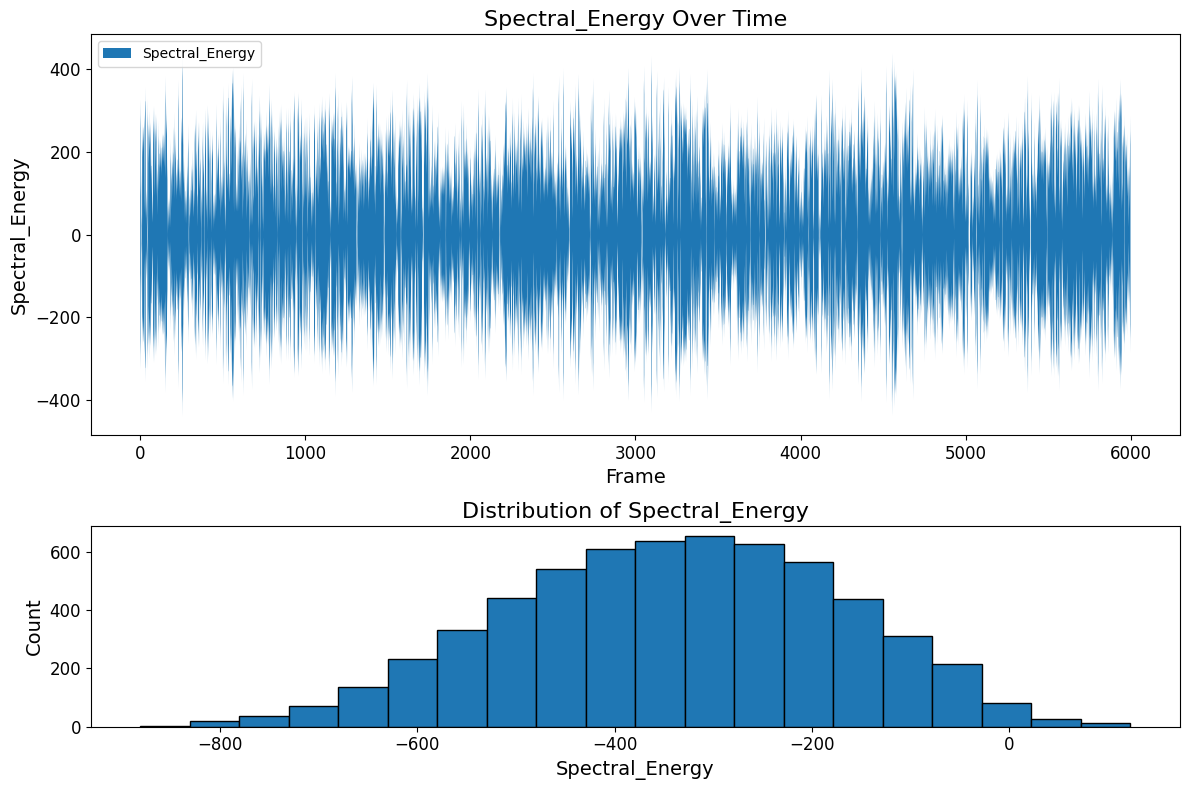

In [12]:
visualize_feature(metadata,'Spectral_Energy')

## Spectral_Shape_1

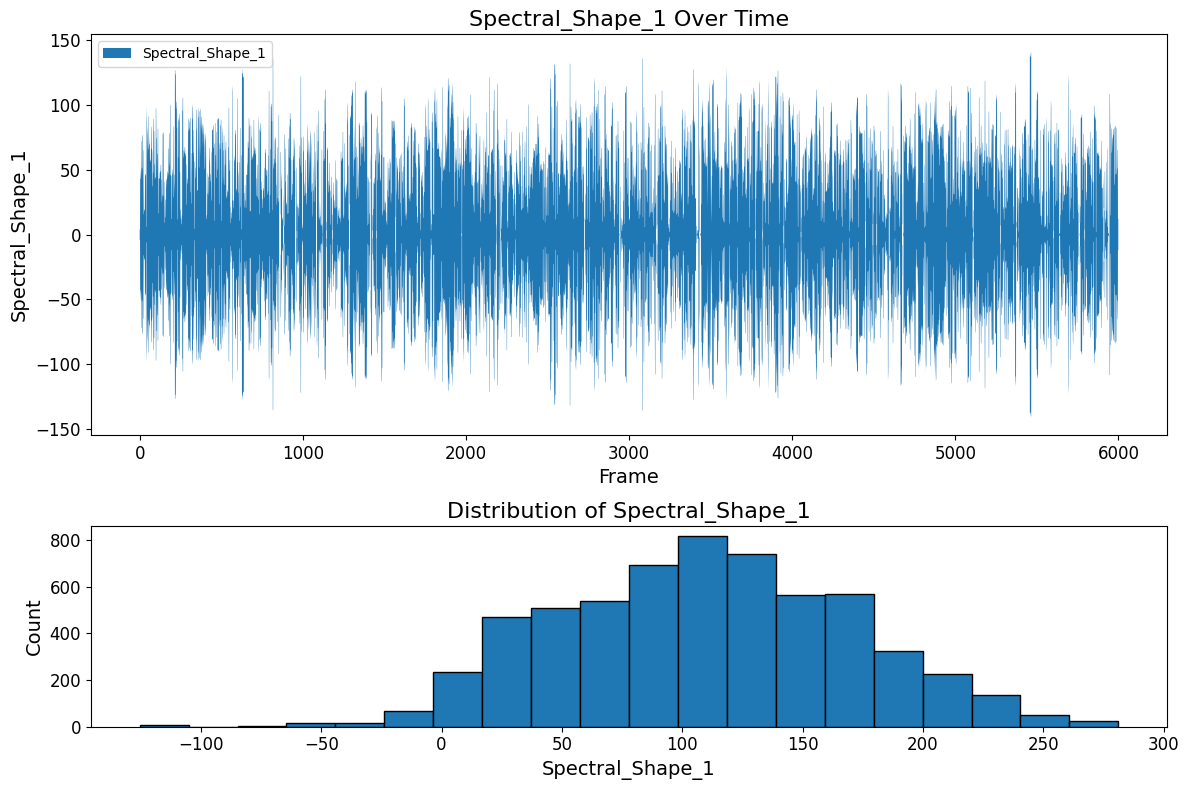

In [13]:
visualize_feature(metadata,'Spectral_Shape_1')

## Spectral_Shape_2

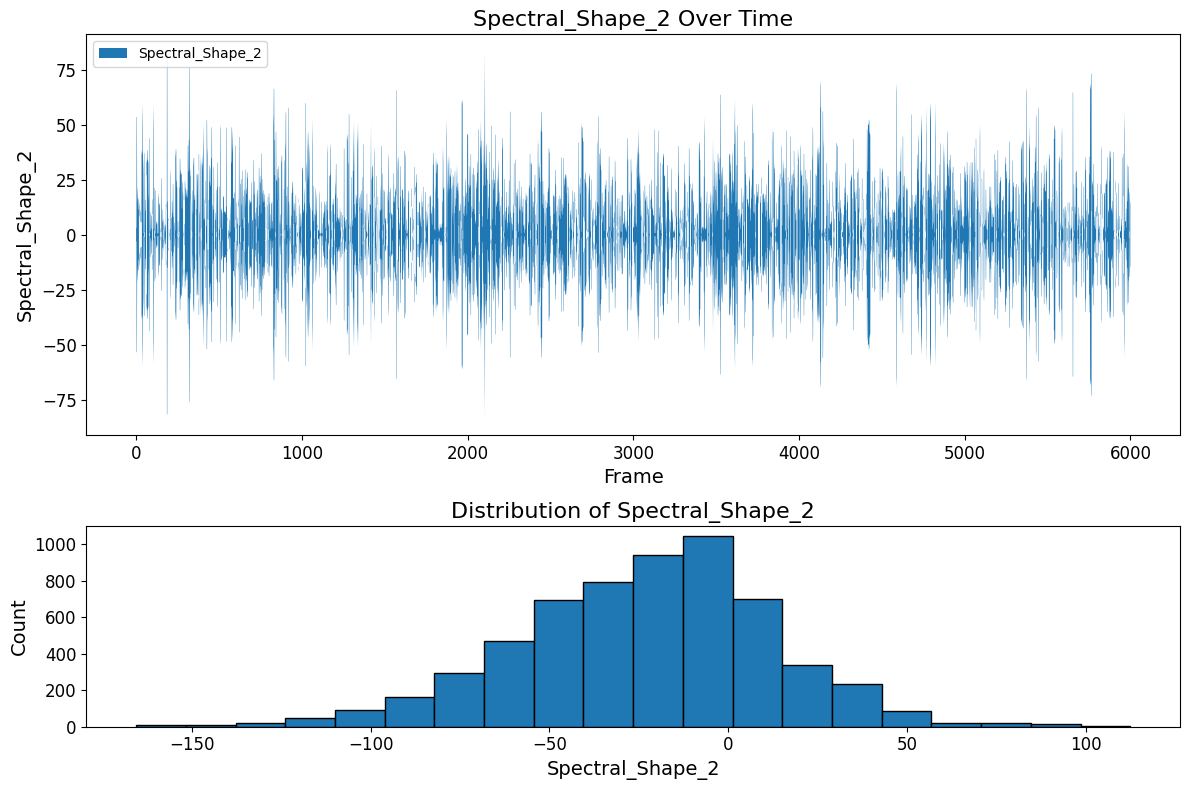

In [14]:
visualize_feature(metadata,'Spectral_Shape_2')

## Spectral_Shape_3

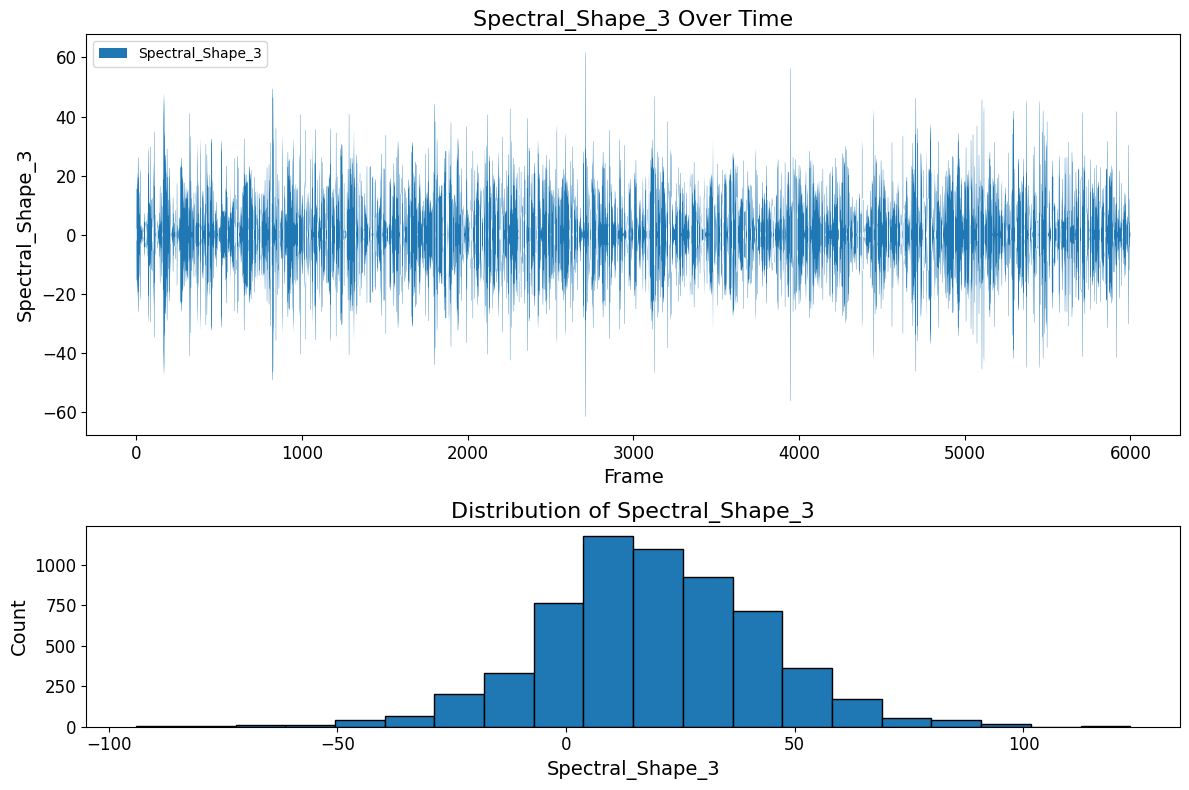

In [15]:
visualize_feature(metadata,'Spectral_Shape_3')

## Fine_Spectral_Texture_1

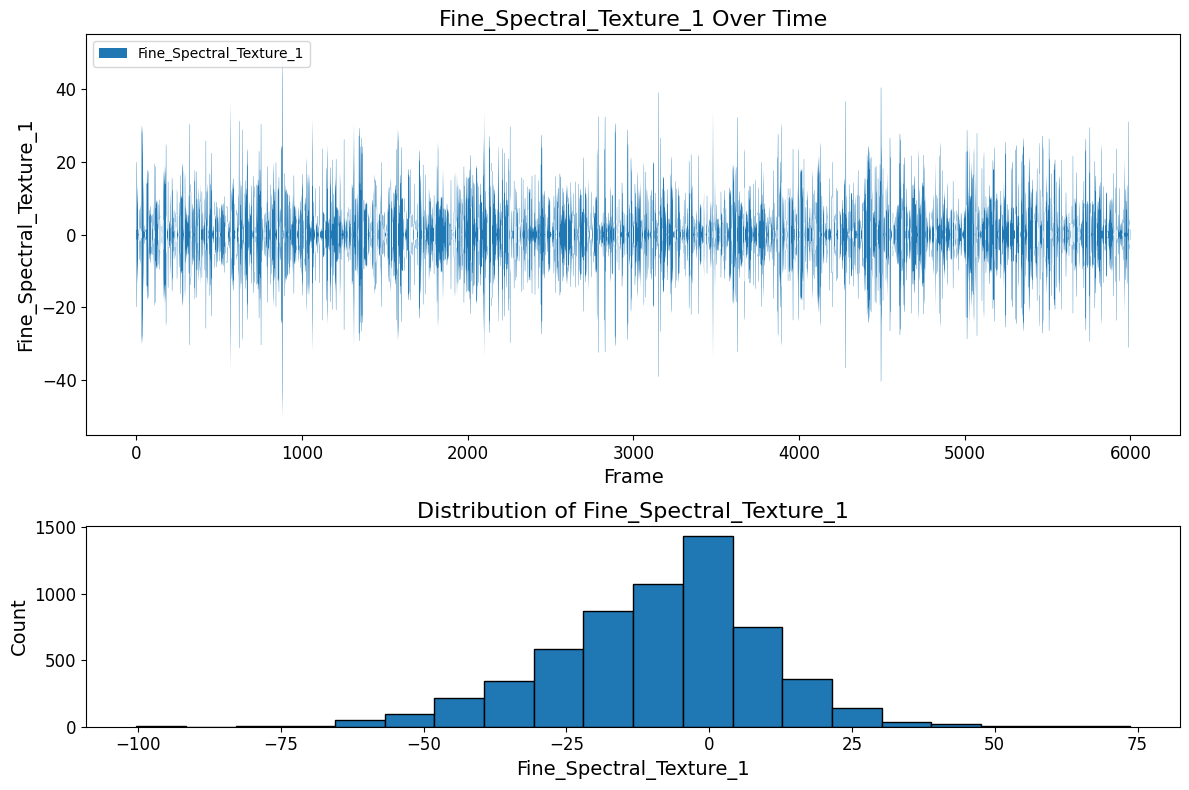

In [16]:
visualize_feature(metadata,'Fine_Spectral_Texture_1')

## Fine_Spectral_Texture_2

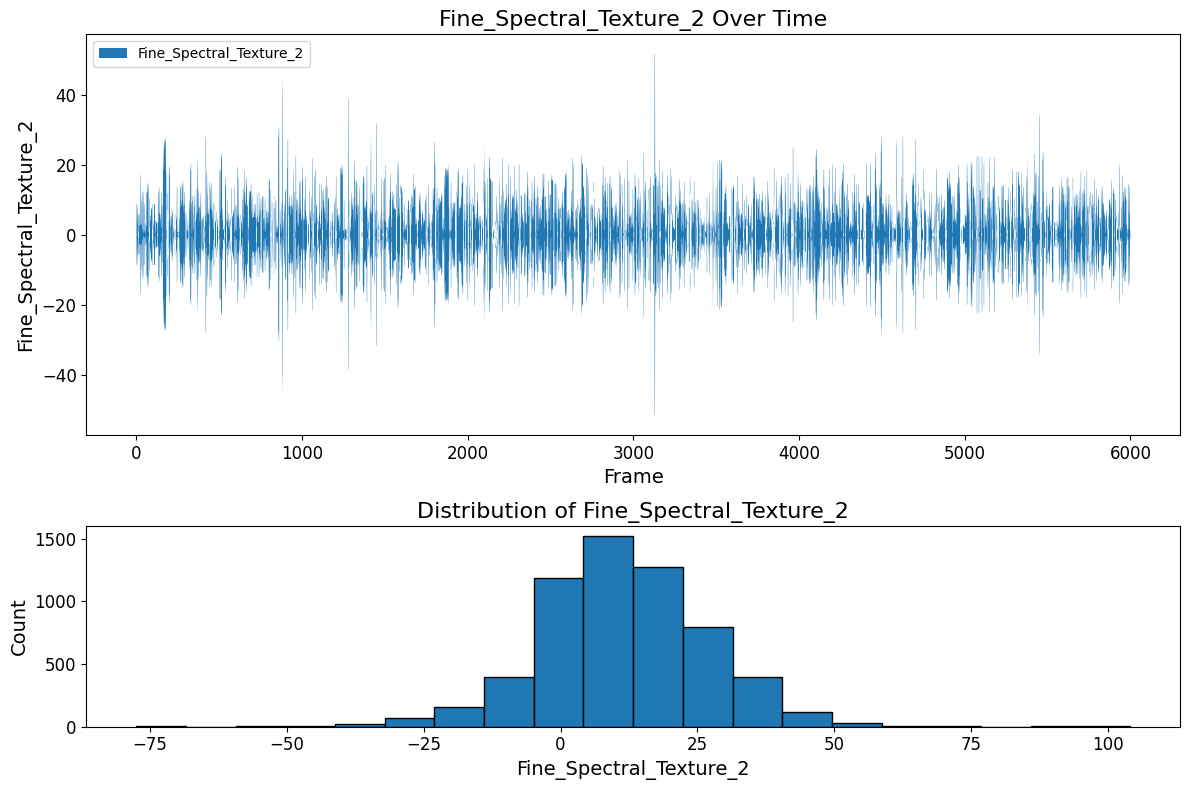

In [17]:
visualize_feature(metadata,'Fine_Spectral_Texture_2')

## Fine_Spectral_Texture_3

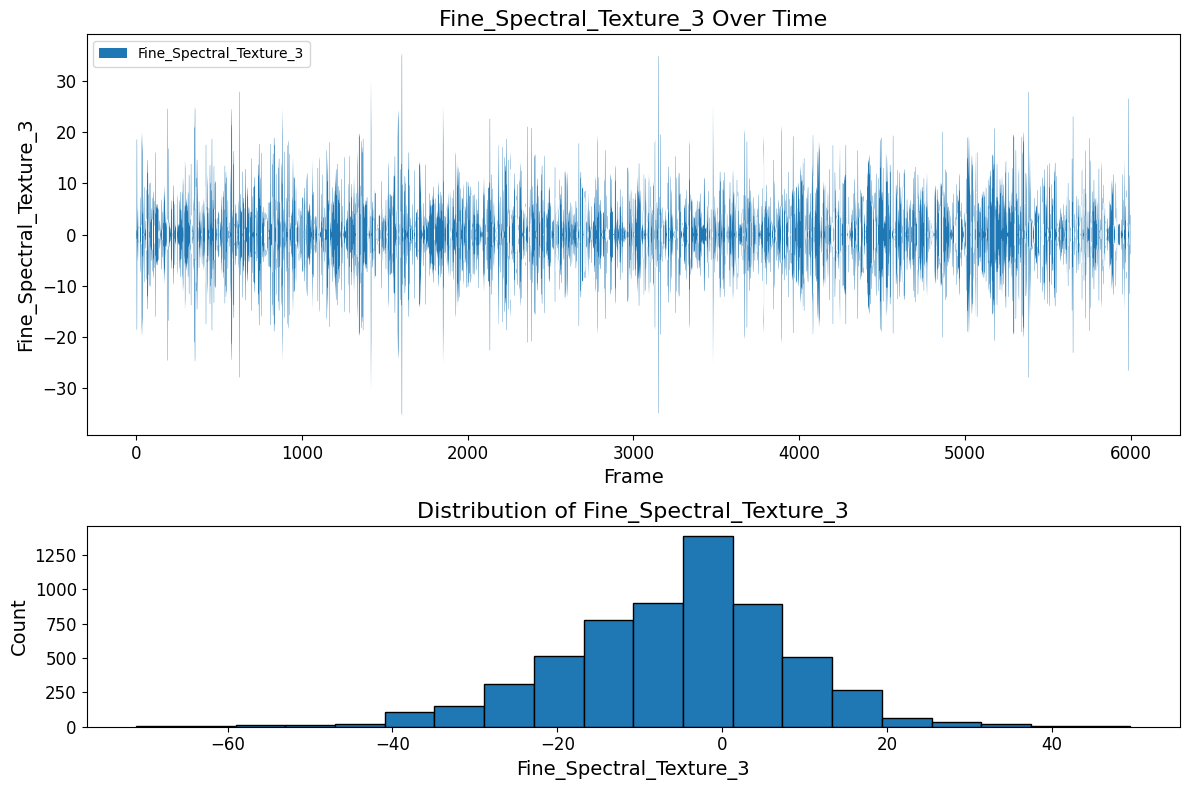

In [18]:
visualize_feature(metadata,'Fine_Spectral_Texture_3')

## Fine_Timbral_Detail_1

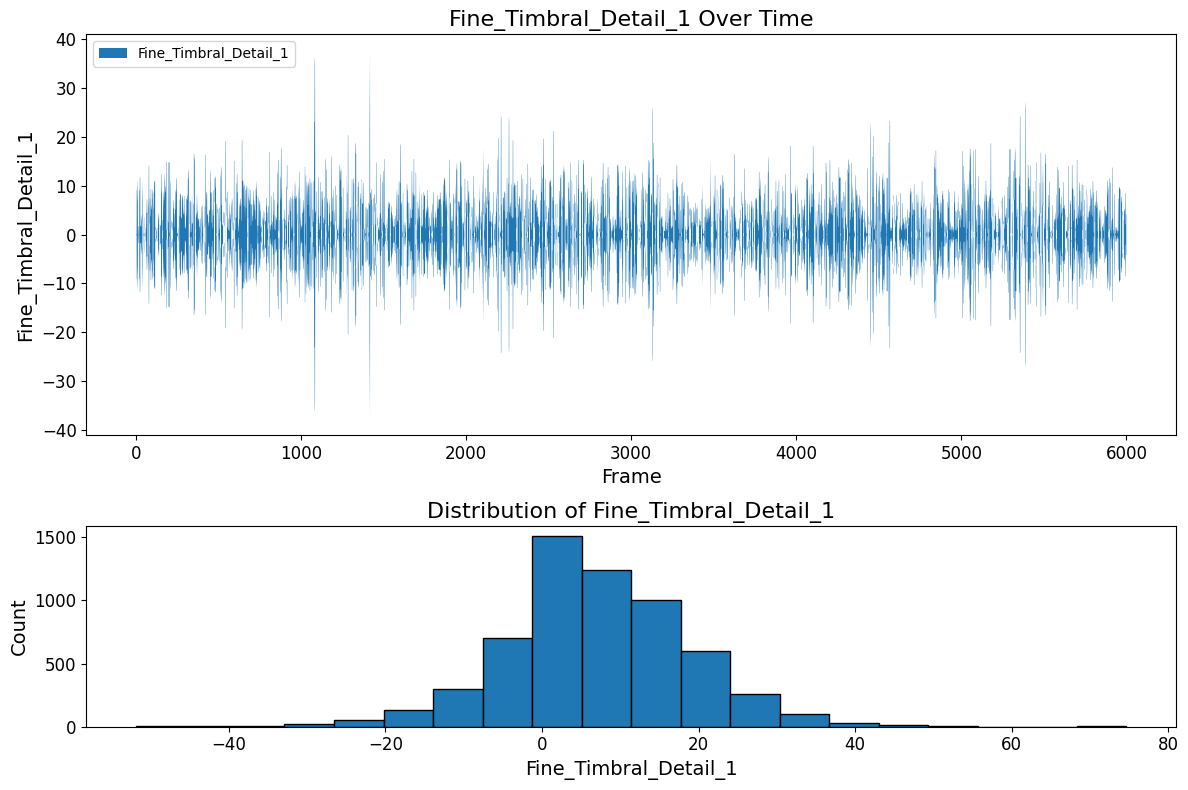

In [19]:
visualize_feature(metadata,'Fine_Timbral_Detail_1')

## Fine_Timbral_Detail_2

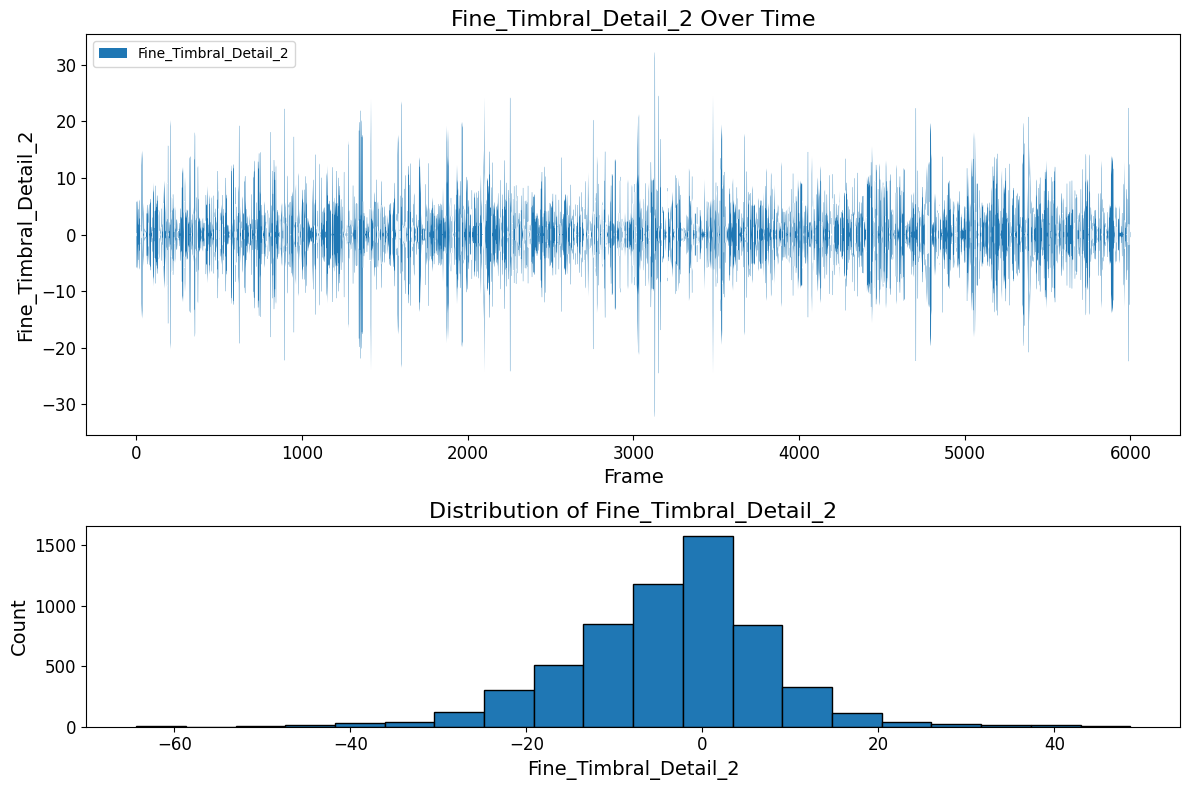

In [20]:
visualize_feature(metadata,'Fine_Timbral_Detail_2')

## Fine_Timbral_Detail_3

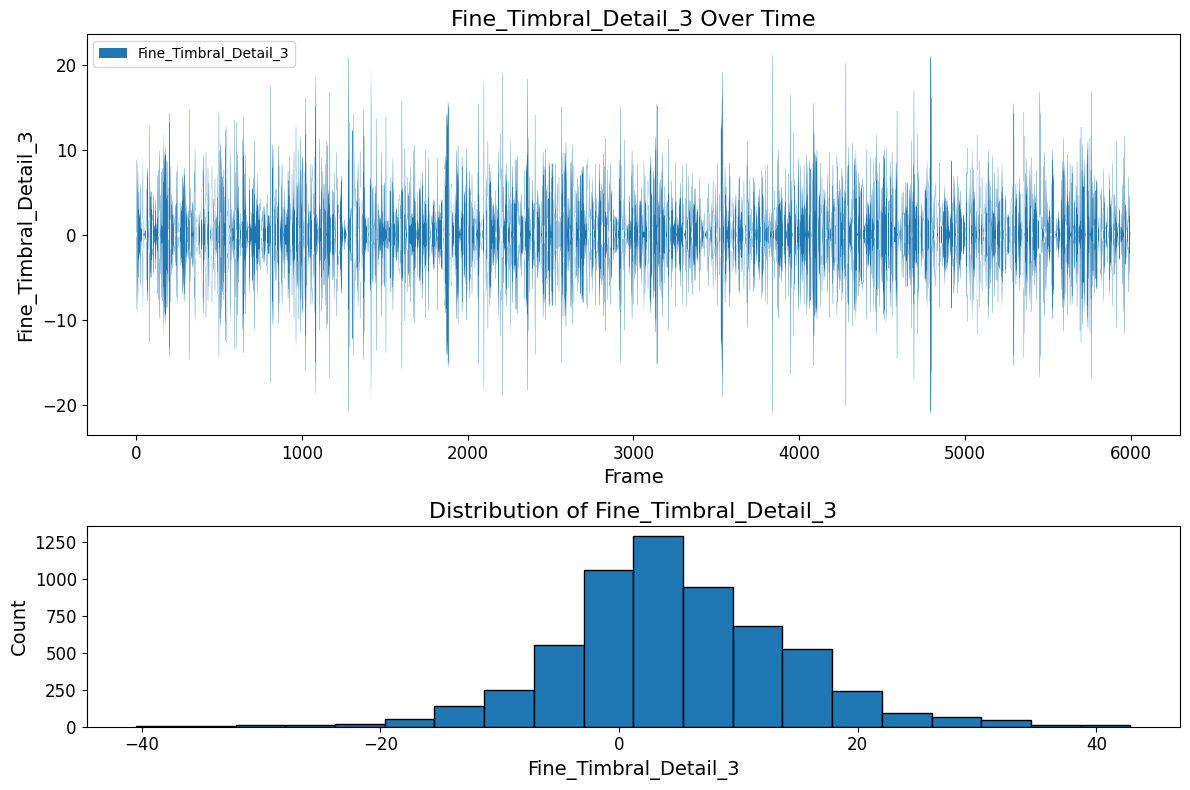

In [21]:
visualize_feature(metadata,'Fine_Timbral_Detail_3')

## Subtle_Timbral_Variation_1

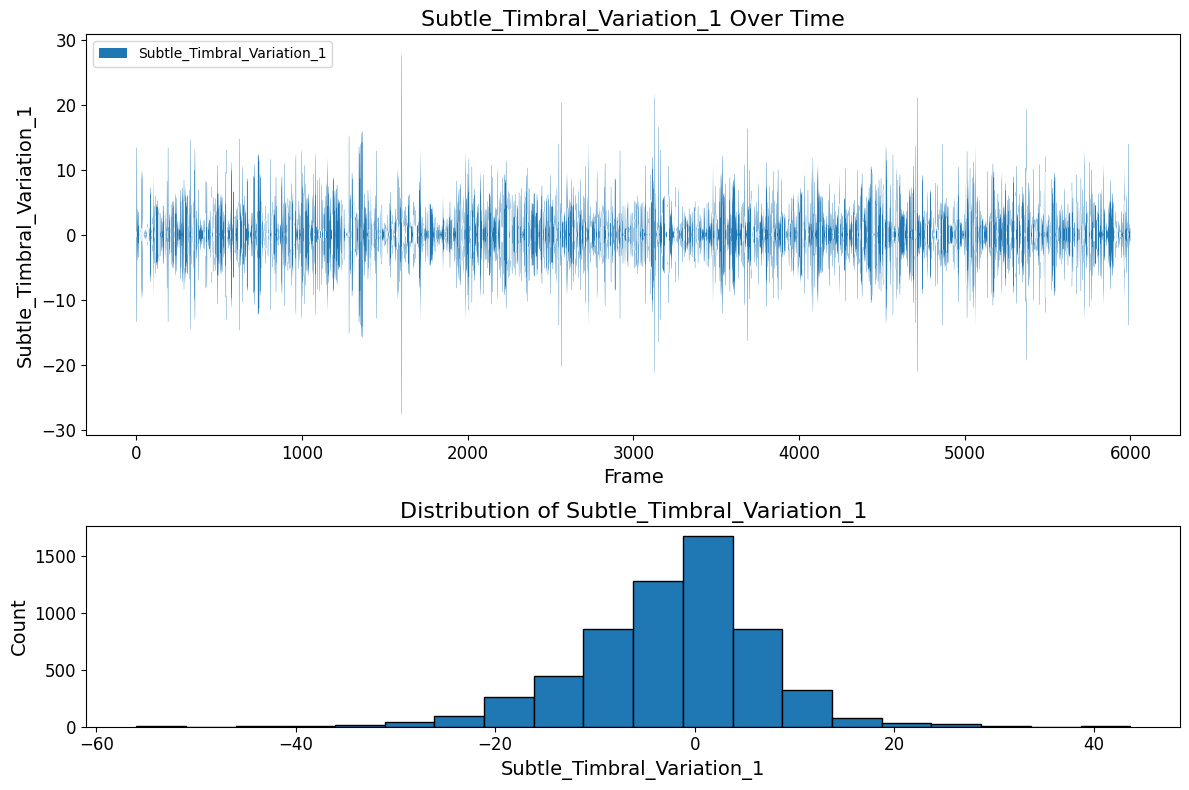

In [22]:
visualize_feature(metadata,'Subtle_Timbral_Variation_1')

## Subtle_Timbral_Variation_2

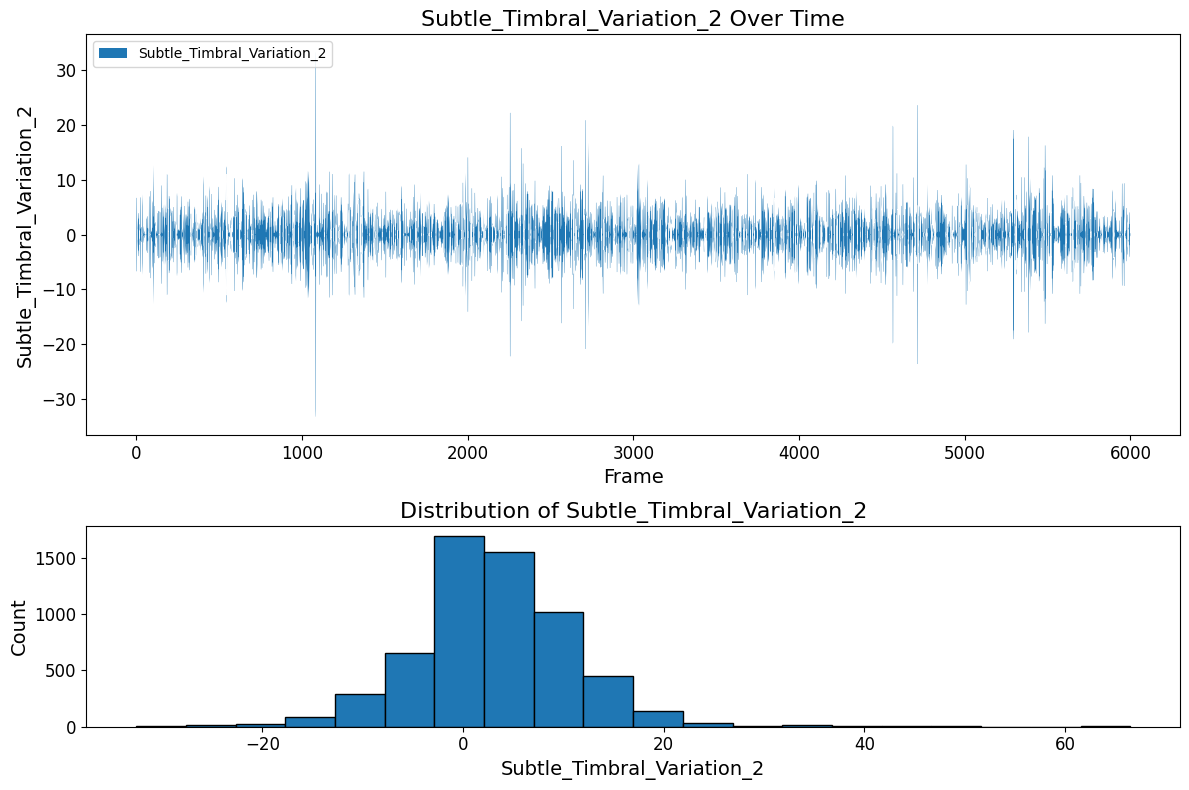

In [23]:
visualize_feature(metadata,'Subtle_Timbral_Variation_2')

## Subtle_Timbral_Variation_3

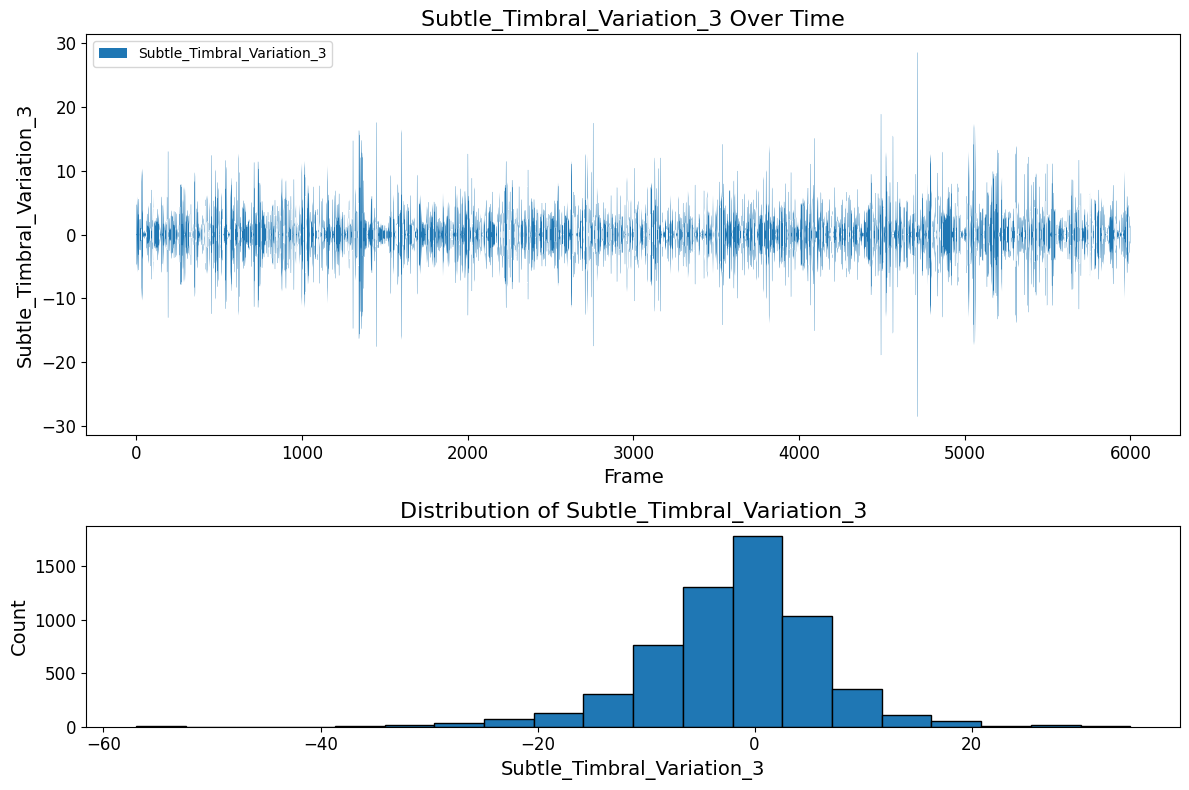

In [24]:
visualize_feature(metadata,'Subtle_Timbral_Variation_3')

## Spectral_Centroid

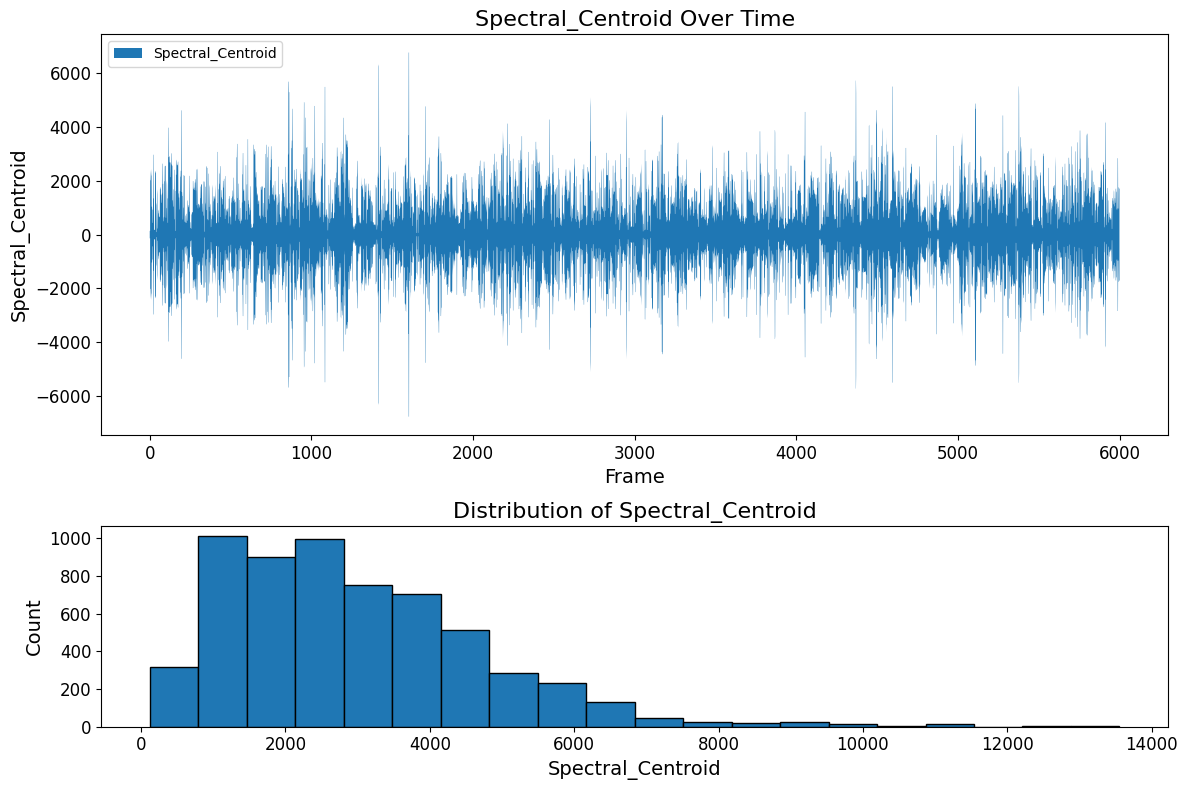

In [25]:
visualize_feature(metadata,'Spectral_Centroid')

## Spectral_Bandwidth

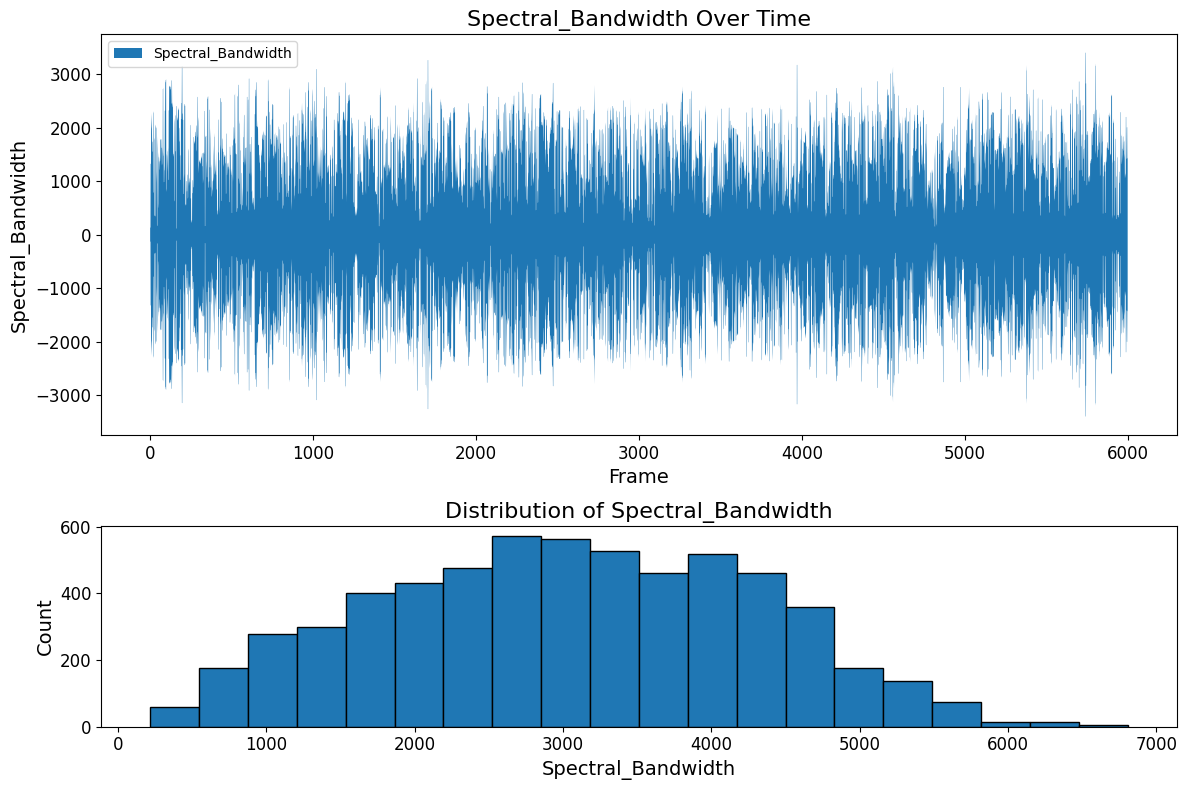

In [26]:
visualize_feature(metadata,'Spectral_Bandwidth')

## Spectral Contrast Features

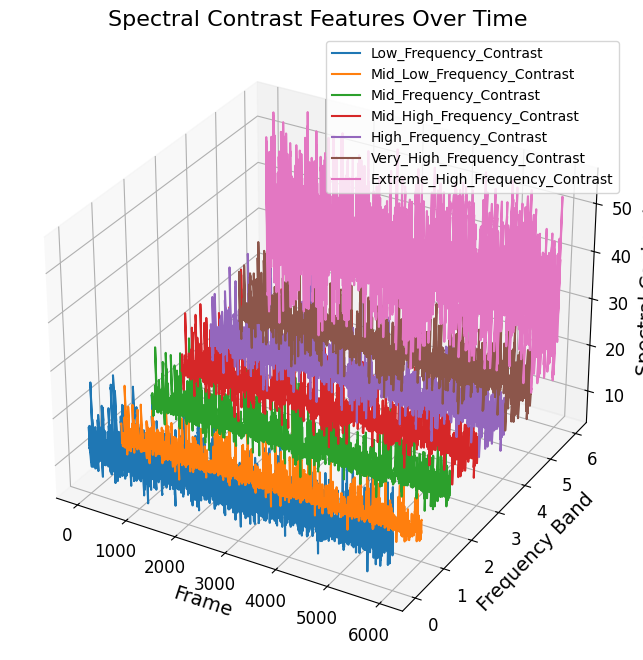

In [27]:
spectral_contrast_features = ['Low_Frequency_Contrast', 'Mid_Low_Frequency_Contrast', 
                              'Mid_Frequency_Contrast', 'Mid_High_Frequency_Contrast',
                              'High_Frequency_Contrast', 'Very_High_Frequency_Contrast',
                              'Extreme_High_Frequency_Contrast']

# Assuming you have the metadata dataframe with the Spectral Contrast features
spectral_contrast_df = metadata[spectral_contrast_features]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(np.arange(spectral_contrast_df.shape[0]), np.arange(spectral_contrast_df.shape[1]))
Z = spectral_contrast_df.values.T

for i in range(Z.shape[0]):
    ax.plot(X[i], Y[i], Z[i], label=spectral_contrast_features[i])

ax.set_title('Spectral Contrast Features Over Time', fontsize=16)
ax.set_xlabel('Frame', fontsize=14)
ax.set_ylabel('Frequency Band', fontsize=14)
ax.set_zlabel('Spectral Contrast', fontsize=14)
ax.tick_params(labelsize=12)
ax.legend()

plt.show()

## Spectral Rollof


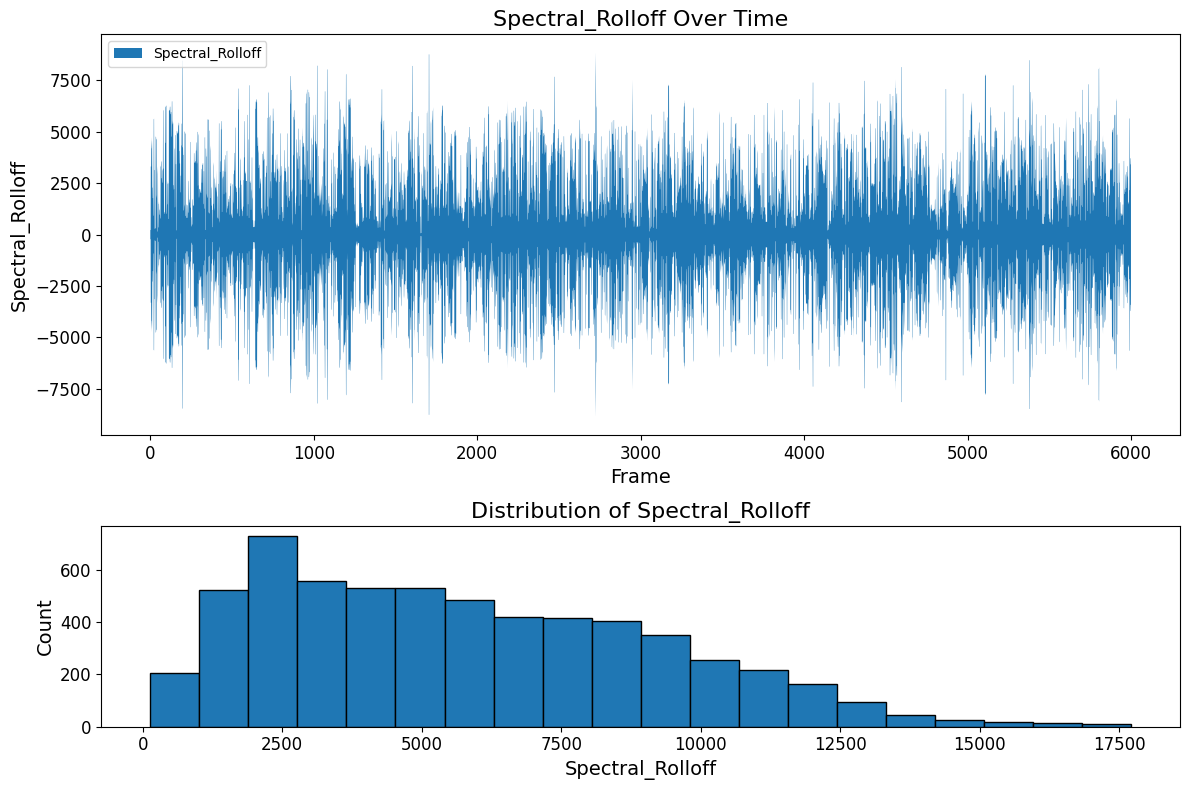

In [28]:
visualize_feature(metadata, 'Spectral_Rolloff')

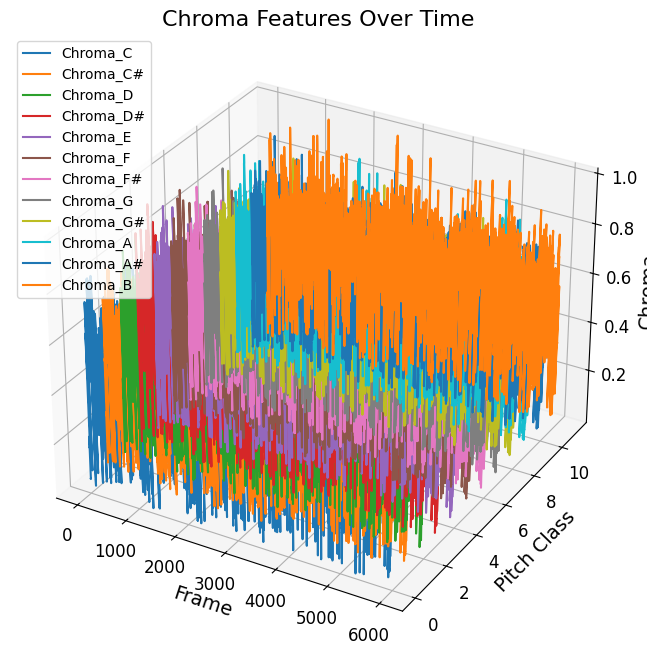

In [29]:
import matplotlib.pyplot as plt
import numpy as np

chroma_features = ['Chroma_C', 'Chroma_C#', 'Chroma_D', 'Chroma_D#', 'Chroma_E', 'Chroma_F', 'Chroma_F#', 'Chroma_G', 'Chroma_G#', 'Chroma_A', 'Chroma_A#', 'Chroma_B']

# Assuming you have the metadata dataframe with the Chroma features
chroma_df = metadata[chroma_features]

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(np.arange(chroma_df.shape[0]), np.arange(chroma_df.shape[1]))
Z = chroma_df.values.T

for i in range(Z.shape[0]):
    ax.plot(X[i], Y[i], Z[i], label=chroma_features[i])

ax.set_title('Chroma Features Over Time', fontsize=16)
ax.set_xlabel('Frame', fontsize=14)
ax.set_ylabel('Pitch Class', fontsize=14)
ax.set_zlabel('Chroma', fontsize=14)
ax.tick_params(labelsize=12)
ax.legend()

plt.show()

## Zero_Crossing_Rate

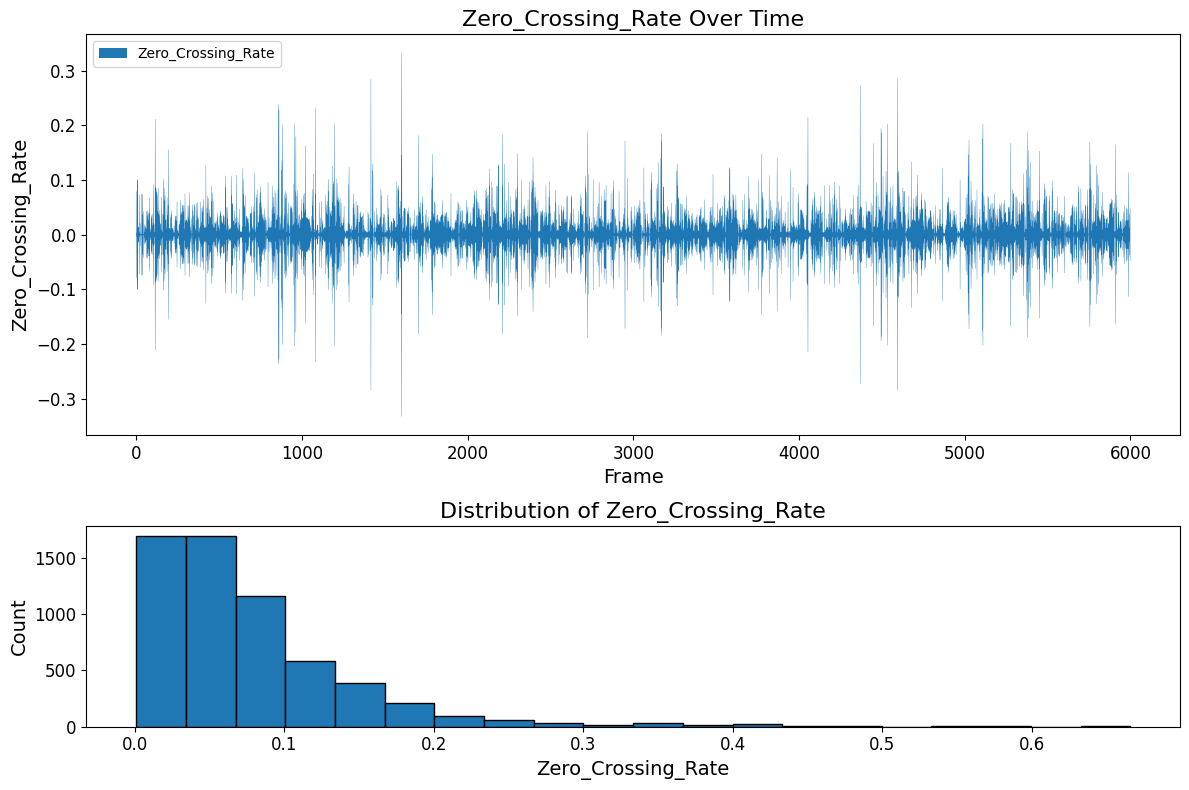

In [30]:
visualize_feature(metadata, 'Zero_Crossing_Rate')

## RMS_Energy

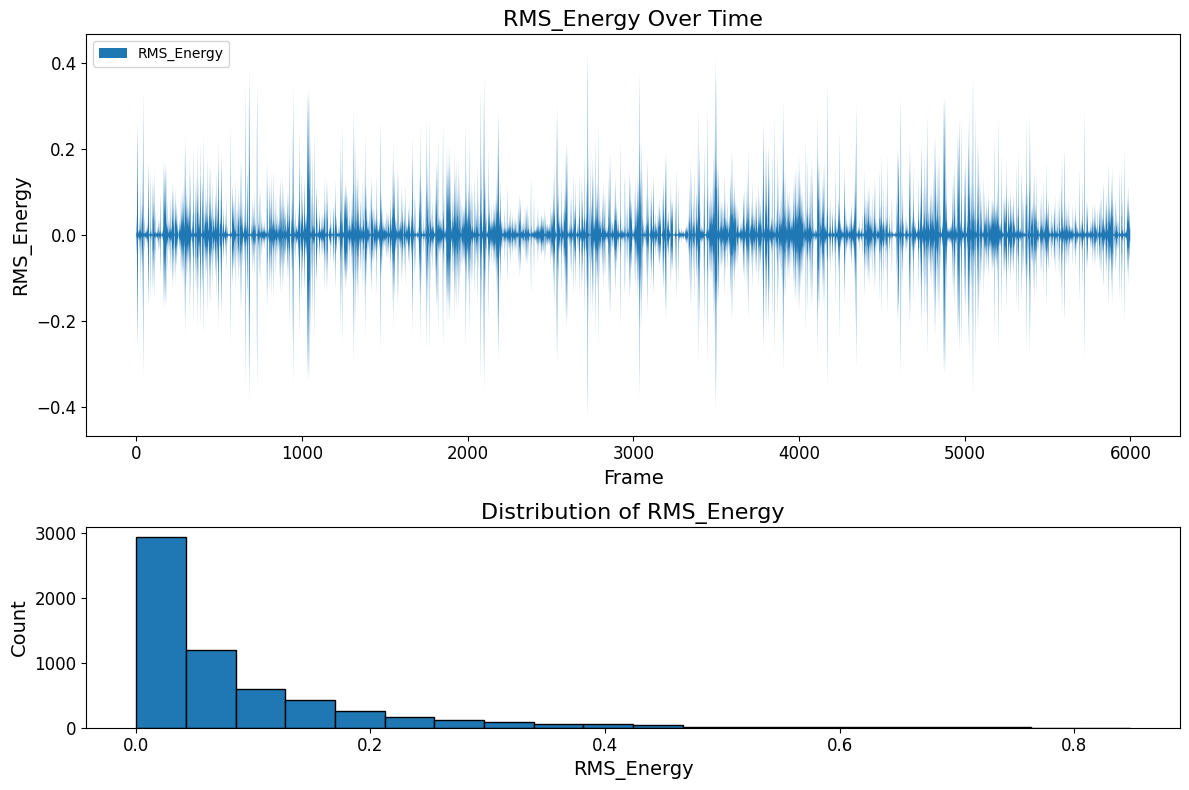

In [31]:
visualize_feature(metadata, 'RMS_Energy')

# Correlation
When identifying correlation between the different features, the team has decided to do 2 different types of correlation. The first correlation analysis is to determine correlation on features on a animal basis. We do this correlation on the entire dataset, by creating a column called `is_animal`.

In [32]:
metadata['is_animal'] = np.where(metadata['category'].isin(animal_categories), 1, 0)
metadata.head()

category                  filename  Spectral_Energy  \
0                dog          1-100032-A-0.wav      -581.739929   
2000             dog   1-100032-A-0_higher.wav      -513.559631   
2001             dog    1-100032-A-0_lower.wav      -649.853699   
1     chirping_birds         1-100038-A-14.wav      -254.936310   
2002  chirping_birds  1-100038-A-14_higher.wav      -186.632996   

      Spectral_Shape_1  Spectral_Shape_2  Spectral_Shape_3  \
0             8.207122         -6.658803         -4.290906   
2000          8.169988         -5.804877         -3.770867   
2001          8.209495         -6.656574         -4.288518   
1            85.839622       -107.103157         31.011576   
2002         85.752045       -106.850655         30.957167   

      Fine_Spectral_Texture_1  Fine_Spectral_Texture_2  \
0                   -3.034478                 0.259279   
2000                -2.435952                 0.241496   
2001                -3.032670                 0.261461   
1                  -39.987736               -17.290342   
2002               -39.775810               -17.305708   

      Fine_Spectral_Texture_3  Fine_Timbral_Detail_1  ...  Chroma_F  \
0                   -1.963946              -0.271577  ...  0.018501   
2000                -1.235061              -0.285446  ...  0.018785   
2001                -1.962061              -0.269821  ...  0.017798   
1                  -37.214104             -18.145691  ...  0.370746   
2002               -37.043076             -18.121487  ...  0.370746   

      Chroma_F#  Chroma_G  Chroma_G#  Chroma_A  Chroma_A#  Chroma_B  \
0      0.017698  0.028559   0.063234  0.053491   0.022580  0.027154   
2000   0.017654  0.025020   0.058404  0.059829   0.024756  0.025157   
2001   0.017214  0.027870   0.062679  0.053323   0.022173  0.027311   
1      0.372750  0.455916   0.449673  0.240554   0.221091  0.203570   
2002   0.372750  0.455918   0.449673  0.240554   0.221091  0.203570   

      Zero_Crossing_Rate  RMS_Energy  is_animal  
0               0.007329    0.007518          1  
2000            0.007329    0.014233          1  
2001            0.007329    0.003759          1  
1               0.157994    0.048115          1  
2002            0.157994    0.096224          1  

[5 rows x 40 columns]

In [33]:
cleaned_metadata = metadata.drop(columns=['filename','category'])
cleaned_metadata.head()

Spectral_Energy  Spectral_Shape_1  Spectral_Shape_2  Spectral_Shape_3  \
0         -581.739929          8.207122         -6.658803         -4.290906   
2000      -513.559631          8.169988         -5.804877         -3.770867   
2001      -649.853699          8.209495         -6.656574         -4.288518   
1         -254.936310         85.839622       -107.103157         31.011576   
2002      -186.632996         85.752045       -106.850655         30.957167   

      Fine_Spectral_Texture_1  Fine_Spectral_Texture_2  \
0                   -3.034478                 0.259279   
2000                -2.435952                 0.241496   
2001                -3.032670                 0.261461   
1                  -39.987736               -17.290342   
2002               -39.775810               -17.305708   

      Fine_Spectral_Texture_3  Fine_Timbral_Detail_1  Fine_Timbral_Detail_2  \
0                   -1.963946              -0.271577               0.518284   
2000                -1.235061              -0.285446               0.604016   
2001                -1.962061              -0.269821               0.520418   
1                  -37.214104             -18.145691             -11.705071   
2002               -37.043076             -18.121487             -11.573458   

      Fine_Timbral_Detail_3  ...  Chroma_F  Chroma_F#  Chroma_G  Chroma_G#  \
0                  0.341884  ...  0.018501   0.017698  0.028559   0.063234   
2000               0.566948  ...  0.018785   0.017654  0.025020   0.058404   
2001               0.343702  ...  0.017798   0.017214  0.027870   0.062679   
1                -17.621454  ...  0.370746   0.372750  0.455916   0.449673   
2002             -17.572086  ...  0.370746   0.372750  0.455918   0.449673   

      Chroma_A  Chroma_A#  Chroma_B  Zero_Crossing_Rate  RMS_Energy  is_animal  
0     0.053491   0.022580  0.027154            0.007329    0.007518          1  
2000  0.059829   0.024756  0.025157            0.007329    0.014233          1  
2001  0.053323   0.022173  0.027311            0.007329    0.003759          1  
1     0.240554   0.221091  0.203570            0.157994    0.048115          1  
2002  0.240554   0.221091  0.203570            0.157994    0.096224          1  

[5 rows x 38 columns]

## Correlation between audio features and animals

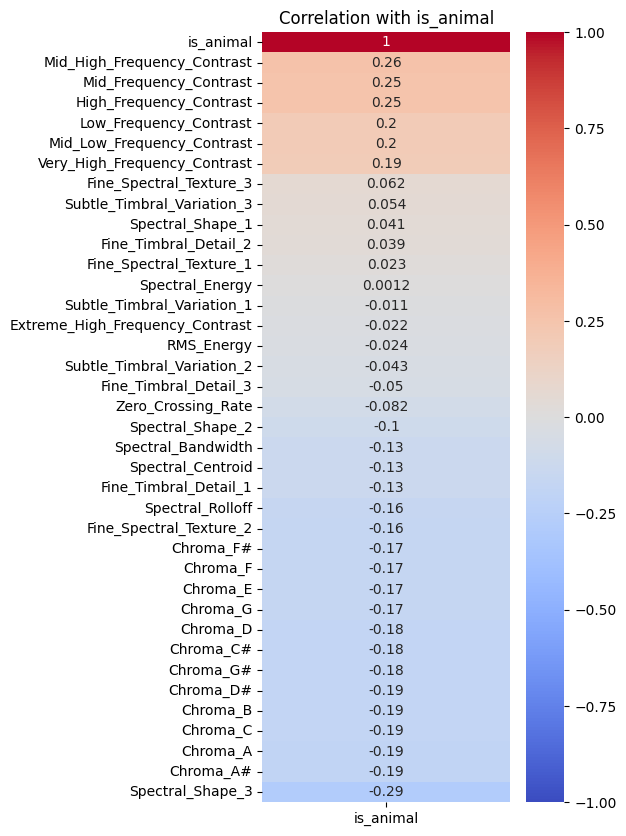

In [34]:
corr_matrix = cleaned_metadata.corr()

# Focus on the 'is_animal' correlations
corr_with_is_animal = corr_matrix[['is_animal']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_animal.sort_values(by='is_animal', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with is_animal')

# Show the plot
plt.show()

In [35]:
# Map categories to numerical values
category_mapping = {category: index + 1 for index, category in enumerate(animal_categories)}

# Add numerical values to the DataFrame
metadata['category_numeric'] = metadata['category'].map(category_mapping)

#remove the non-numerical columns
cleaned_metadata1 = metadata.drop(columns=['filename', 'category'])

cleaned_metadata1.head()

Spectral_Energy  Spectral_Shape_1  Spectral_Shape_2  Spectral_Shape_3  \
0         -581.739929          8.207122         -6.658803         -4.290906   
2000      -513.559631          8.169988         -5.804877         -3.770867   
2001      -649.853699          8.209495         -6.656574         -4.288518   
1         -254.936310         85.839622       -107.103157         31.011576   
2002      -186.632996         85.752045       -106.850655         30.957167   

      Fine_Spectral_Texture_1  Fine_Spectral_Texture_2  \
0                   -3.034478                 0.259279   
2000                -2.435952                 0.241496   
2001                -3.032670                 0.261461   
1                  -39.987736               -17.290342   
2002               -39.775810               -17.305708   

      Fine_Spectral_Texture_3  Fine_Timbral_Detail_1  Fine_Timbral_Detail_2  \
0                   -1.963946              -0.271577               0.518284   
2000                -1.235061              -0.285446               0.604016   
2001                -1.962061              -0.269821               0.520418   
1                  -37.214104             -18.145691             -11.705071   
2002               -37.043076             -18.121487             -11.573458   

      Fine_Timbral_Detail_3  ...  Chroma_F#  Chroma_G  Chroma_G#  Chroma_A  \
0                  0.341884  ...   0.017698  0.028559   0.063234  0.053491   
2000               0.566948  ...   0.017654  0.025020   0.058404  0.059829   
2001               0.343702  ...   0.017214  0.027870   0.062679  0.053323   
1                -17.621454  ...   0.372750  0.455916   0.449673  0.240554   
2002             -17.572086  ...   0.372750  0.455918   0.449673  0.240554   

      Chroma_A#  Chroma_B  Zero_Crossing_Rate  RMS_Energy  is_animal  \
0      0.022580  0.027154            0.007329    0.007518          1   
2000   0.024756  0.025157            0.007329    0.014233          1   
2001   0.022173  0.027311            0.007329    0.003759          1   
1      0.221091  0.203570            0.157994    0.048115          1   
2002   0.221091  0.203570            0.157994    0.096224          1   

      category_numeric  
0                  1.0  
2000               1.0  
2001               1.0  
1                  2.0  
2002               2.0  

[5 rows x 39 columns]

Below you can see the features that we have determined that are important in discerning if that sound is made by an animal

In [36]:
# Identifying important features to determine whether sound is made by an animal
important_features_1 = ['Spectral_Shape_3', 'Low_Frequency_Contrast', 'Mid_Low_Frequency_Contrast', 'Mid_Frequency_Contrast',
'Mid_High_Frequency_Contrast', 'High_Frequency_Contrast', 'Very_High_Frequency_Contrast',
'Extreme_High_Frequency_Contrast'] + ['Chroma_C', 'Chroma_C#', 'Chroma_D', 'Chroma_D#', 'Chroma_E',
    'Chroma_F', 'Chroma_F#', 'Chroma_G', 'Chroma_G#', 'Chroma_A', 'Chroma_A#', 'Chroma_B']

In [37]:
animal_metadata = metadata[metadata['category'].isin(animal_categories)]
animal_metadata.head()

category                  filename  Spectral_Energy  \
0                dog          1-100032-A-0.wav      -581.739929   
2000             dog   1-100032-A-0_higher.wav      -513.559631   
2001             dog    1-100032-A-0_lower.wav      -649.853699   
1     chirping_birds         1-100038-A-14.wav      -254.936310   
2002  chirping_birds  1-100038-A-14_higher.wav      -186.632996   

      Spectral_Shape_1  Spectral_Shape_2  Spectral_Shape_3  \
0             8.207122         -6.658803         -4.290906   
2000          8.169988         -5.804877         -3.770867   
2001          8.209495         -6.656574         -4.288518   
1            85.839622       -107.103157         31.011576   
2002         85.752045       -106.850655         30.957167   

      Fine_Spectral_Texture_1  Fine_Spectral_Texture_2  \
0                   -3.034478                 0.259279   
2000                -2.435952                 0.241496   
2001                -3.032670                 0.261461   
1                  -39.987736               -17.290342   
2002               -39.775810               -17.305708   

      Fine_Spectral_Texture_3  Fine_Timbral_Detail_1  ...  Chroma_F#  \
0                   -1.963946              -0.271577  ...   0.017698   
2000                -1.235061              -0.285446  ...   0.017654   
2001                -1.962061              -0.269821  ...   0.017214   
1                  -37.214104             -18.145691  ...   0.372750   
2002               -37.043076             -18.121487  ...   0.372750   

      Chroma_G  Chroma_G#  Chroma_A  Chroma_A#  Chroma_B  Zero_Crossing_Rate  \
0     0.028559   0.063234  0.053491   0.022580  0.027154            0.007329   
2000  0.025020   0.058404  0.059829   0.024756  0.025157            0.007329   
2001  0.027870   0.062679  0.053323   0.022173  0.027311            0.007329   
1     0.455916   0.449673  0.240554   0.221091  0.203570            0.157994   
2002  0.455918   0.449673  0.240554   0.221091  0.203570            0.157994   

      RMS_Energy  is_animal  category_numeric  
0       0.007518          1               1.0  
2000    0.014233          1               1.0  
2001    0.003759          1               1.0  
1       0.048115          1               2.0  
2002    0.096224          1               2.0  

[5 rows x 41 columns]

In [38]:
animal_metadata_clean = animal_metadata.drop(columns=['filename'])
animal_metadata_encoded = pd.get_dummies(animal_metadata_clean, columns=['category'])

animal_dataframes = {}

# Loop through each animal category to create a separate DataFrame
for animal in animal_categories:
    # Define the column for the current animal
    animal_column = f'category_{animal}'
    
    # Identify non-category specific columns (i.e., those not starting with 'category_')
    non_category_columns = [col for col in animal_metadata_encoded.columns if not col.startswith('category_')]
    
    # Define columns to keep: non-animal specific + current animal's column
    columns_to_keep = non_category_columns + [animal_column]
    
    # Create a new DataFrame with only the desired columns
    animal_df = animal_metadata_encoded[columns_to_keep].copy()
    
    # Add the new DataFrame to the dictionary with a key for the animal name
    animal_dataframes[animal] = animal_df.drop(columns=['is_animal'])

## Correlation between audio features and dogs

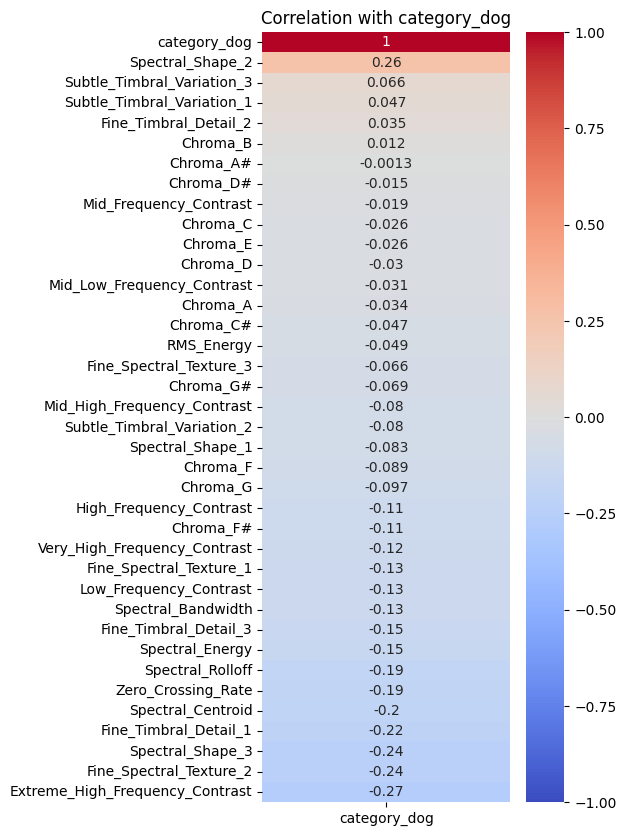

In [39]:
#Correlation for dog
corr_matrix_dog = animal_dataframes['dog'].corr()

# Focus on the 'is_dog' correlations
corr_with_is_dog = corr_matrix_dog[['category_dog']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_dog.sort_values(by='category_dog', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_dog')

# Show the plot
plt.show()

## Correlation between audio features and chirping birds

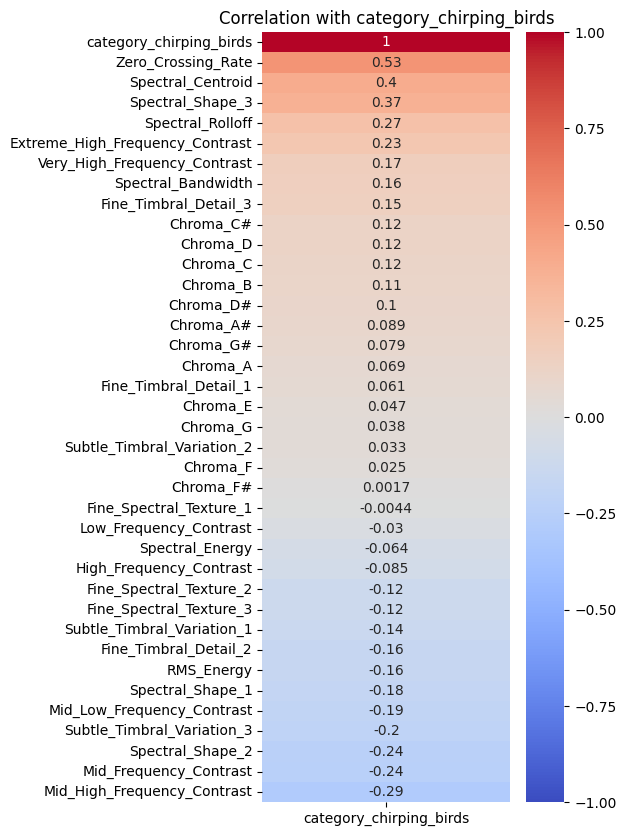

In [40]:
#Correlation for chirping birds
corr_matrix_chirping_birds = animal_dataframes['chirping_birds'].corr()

# Focus on the 'is_chirping_birds' correlations
corr_with_is_chirping_birds = corr_matrix_chirping_birds[['category_chirping_birds']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_chirping_birds.sort_values(by='category_chirping_birds', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_chirping_birds')

# Show the plot
plt.show()

## Correlation between audio features and crows

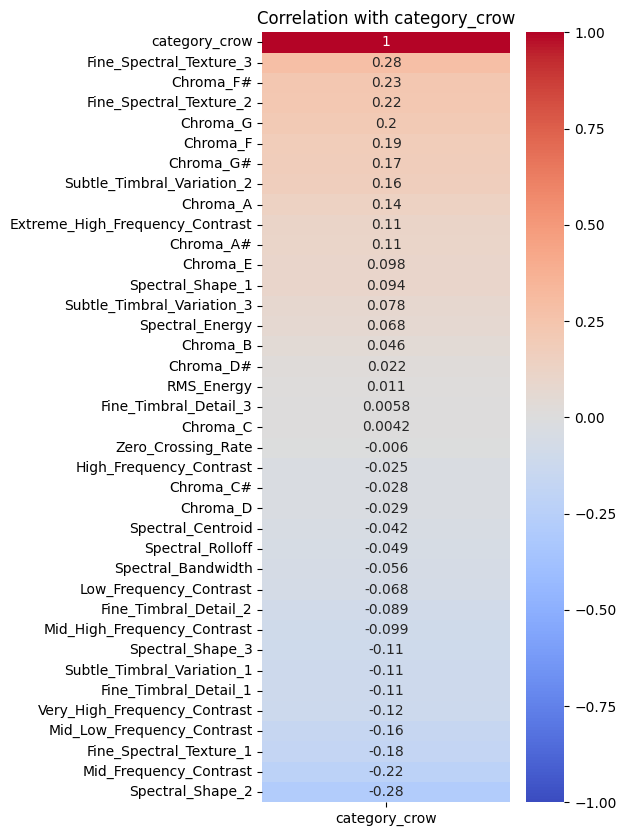

In [41]:
#Correlation for crow
corr_matrix_crow = animal_dataframes['crow'].corr()

# Focus on the 'is_crow' correlations
corr_with_is_crow = corr_matrix_crow[['category_crow']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_crow.sort_values(by='category_crow', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_crow')

# Show the plot
plt.show()

## Correlation between audio features and sheeps

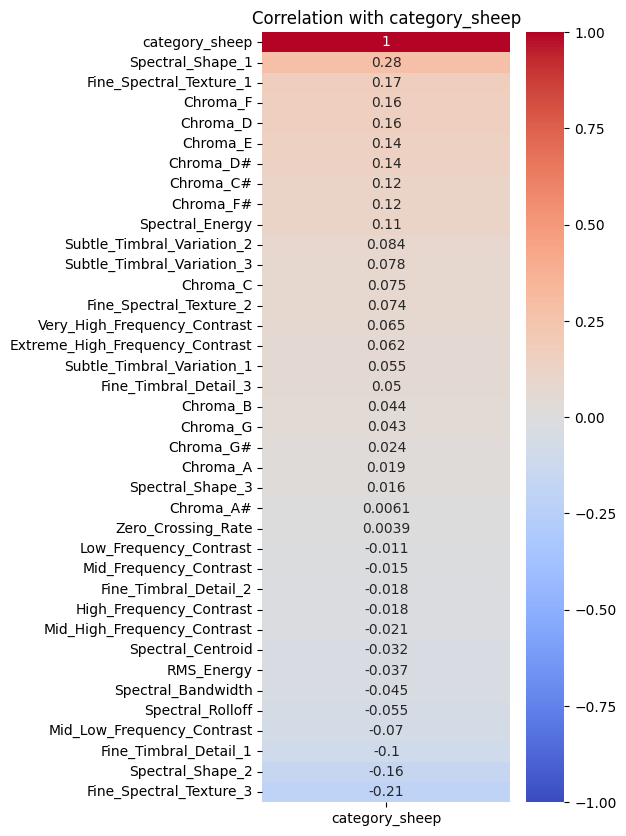

In [42]:
#Correlation for sheep
corr_matrix_sheep = animal_dataframes['sheep'].corr()

# Focus on the 'is_sheep' correlations
corr_with_is_sheep = corr_matrix_sheep[['category_sheep']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_sheep.sort_values(by='category_sheep', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_sheep')

# Show the plot
plt.show()

## Correlation between audio features and frogs

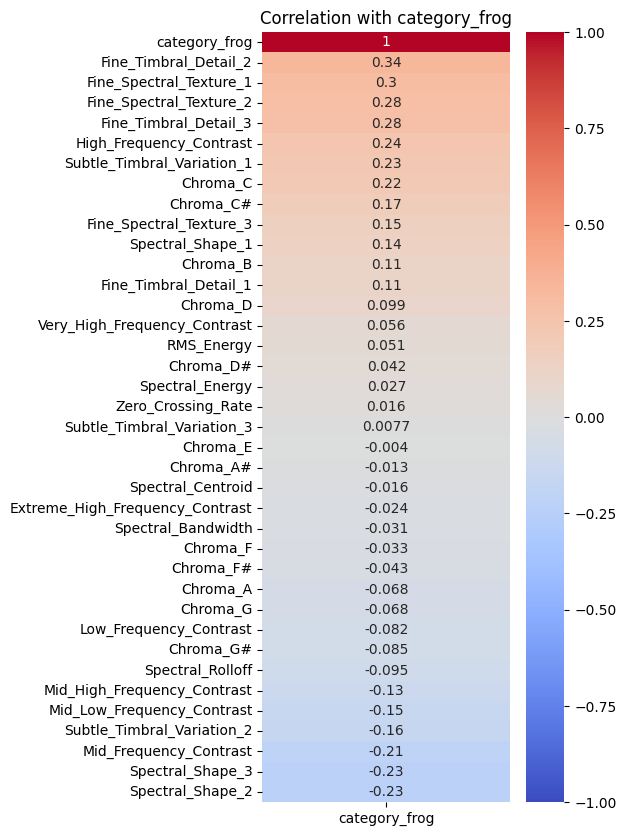

In [43]:
#Correlation for frog
corr_matrix_frog = animal_dataframes['frog'].corr()

# Focus on the 'is_frog' correlations
corr_with_is_frog = corr_matrix_frog[['category_frog']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_frog.sort_values(by='category_frog', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_frog')

# Show the plot
plt.show()

## Correlation between audio features and cows

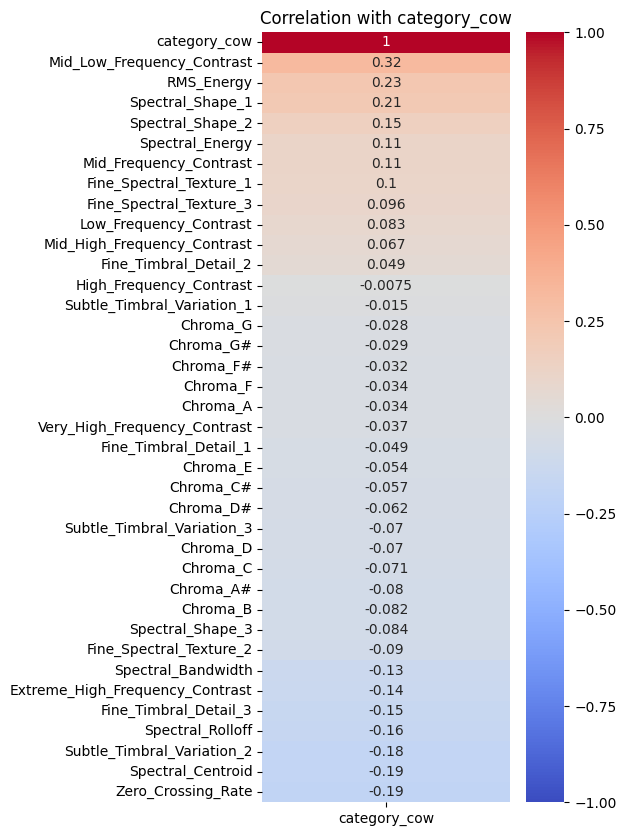

In [44]:
#Correlation for cow
corr_matrix_cow = animal_dataframes['cow'].corr()

# Focus on the 'is_crow' correlations
corr_with_is_cow = corr_matrix_cow[['category_cow']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_cow.sort_values(by='category_cow', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_cow')

# Show the plot
plt.show()

## Correlation between audio features and insects

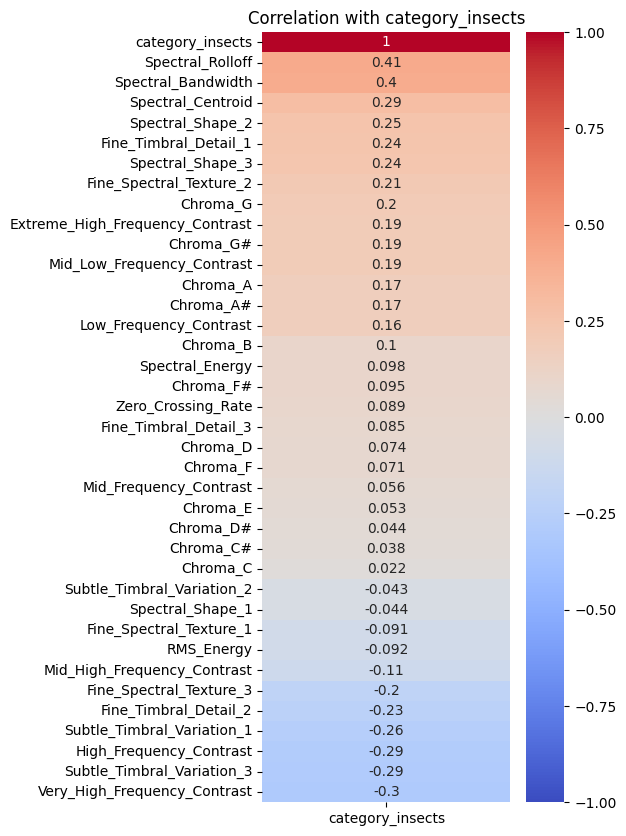

In [45]:
#Correlation for insect
corr_matrix_insects = animal_dataframes['insects'].corr()

# Focus on the 'is_insects' correlations
corr_with_is_insect = corr_matrix_insects[['category_insects']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_insect.sort_values(by='category_insects', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_insects')

# Show the plot
plt.show()

## Correlation between audio features and hens

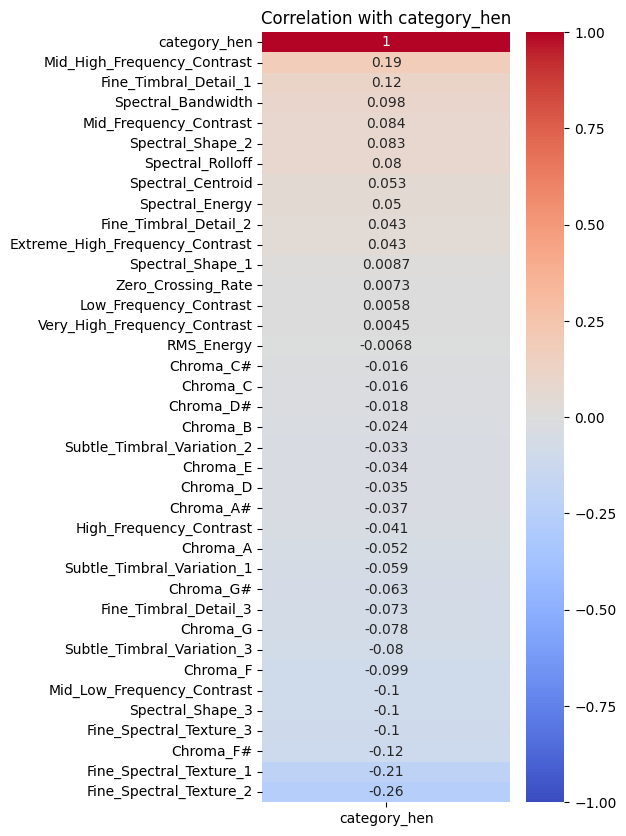

In [46]:
#Correlation for hen
corr_matrix_hen = animal_dataframes['hen'].corr()

# Focus on the 'is_hen' correlations
corr_with_is_hen = corr_matrix_hen[['category_hen']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_hen.sort_values(by='category_hen', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_hen')

# Show the plot
plt.show()

## Correlation between audio features and pigs

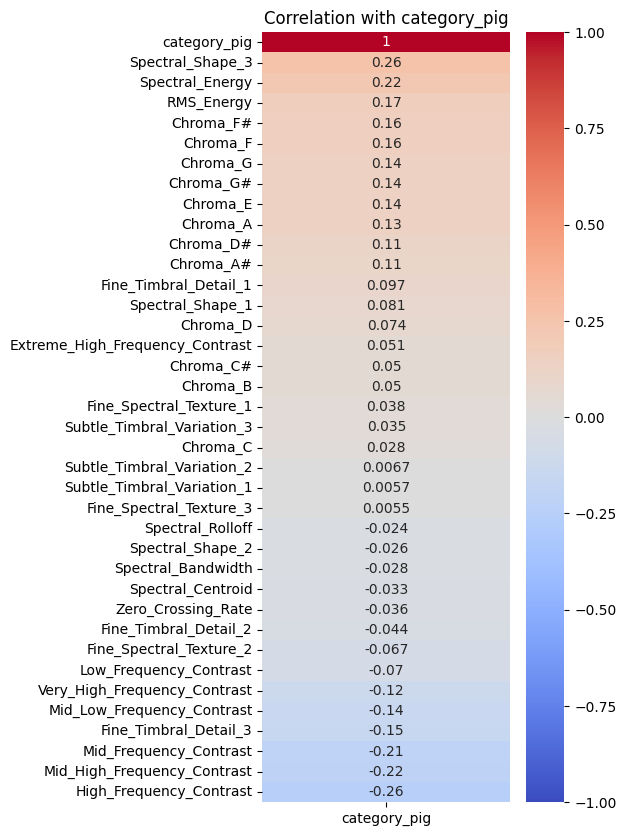

In [47]:
#Correlation for pig
corr_matrix_pig = animal_dataframes['pig'].corr()

# Focus on the 'is_pig' correlations
corr_with_is_pig = corr_matrix_pig[['category_pig']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_pig.sort_values(by='category_pig', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_pig')

# Show the plot
plt.show()

## Correlation between audio features and roosters

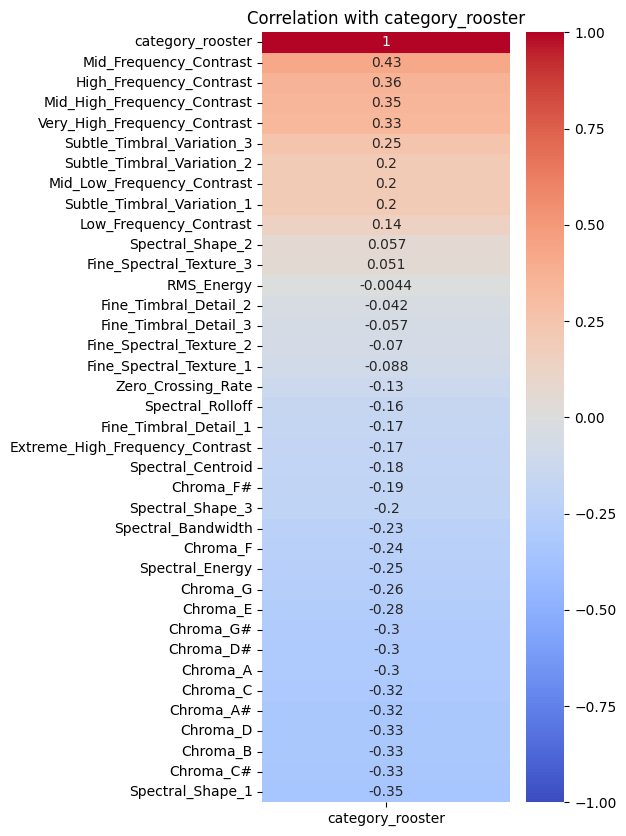

In [48]:
#Correlation for rooster
corr_matrix_rooster = animal_dataframes['rooster'].corr()

# Focus on the 'is_rooster' correlations
corr_with_is_rooster = corr_matrix_rooster[['category_rooster']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_rooster.sort_values(by='category_rooster', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_rooster')

# Show the plot
plt.show()

## Correlation between audio features and cats

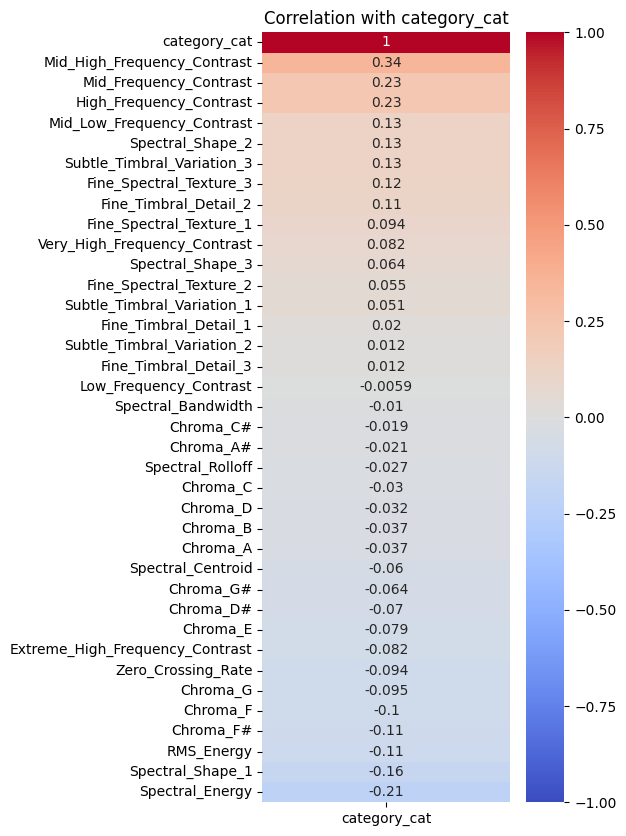

In [49]:
#Correlation for cats
corr_matrix_cat = animal_dataframes['cat'].corr()

# Focus on the 'is_cat' correlations
corr_with_is_cat = corr_matrix_cat[['category_cat']]

# Create a heatmap
plt.figure(figsize=(4, 10))  # Adjust the figure size as needed
sb.heatmap(corr_with_is_cat.sort_values(by='category_cat', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with category_cat')

# Show the plot
plt.show()

In [50]:
# #Comparing important audio feature to different types of animals
# animal_metadata_important = animal_metadata.filter(important_features_1+['category'])

# animal_metadata_important_encoded = pd.get_dummies(animal_metadata_important, columns=['category'])
# correlations_important= animal_metadata_important_encoded.corr()

# # Plotting a heatmap
# plt.figure(figsize=(12, 10))
# sb.heatmap(correlations_important, 
#             cmap='coolwarm', 
#             center=0, 
#             annot=False,  # You can set this to True if you want to see the correlation values
#             fmt=".2f",    # Formatting the annotation if annot=True
#             linewidths=.5,
#             cbar_kws={'shrink': .5, 'label': 'Correlation coefficient'})
# plt.title('Correlation Heatmap between important Audio Features and Animal Categories')
# plt.xticks(rotation=45, ha="right")
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

In [51]:
# # Identifying important features to find out which animal made that sound
# feature_important_columns = [col for col in animal_metadata_important_encoded.columns if not col.startswith('category_')]
# category_important_columns = [col for col in animal_metadata_important_encoded.columns if col.startswith('category_')]

# feature_to_category_corr = correlations_important.loc[feature_important_columns, category_important_columns]

# mean_abs_corr_per_feature = feature_to_category_corr.abs().mean(axis=1)

# # Plotting a bar plot for the mean absolute correlation of each feature with categories
# plt.figure(figsize=(12, 6))
# mean_abs_corr_per_feature.sort_values(ascending=False).plot(kind='bar')
# plt.title('Mean Absolute Correlation of Each Feature with Categories')
# plt.ylabel('Mean Absolute Correlation with Categories')
# plt.xlabel('Features')
# plt.xticks(rotation=45, ha="right")  # Rotate feature names for better readability
# plt.tight_layout()
# plt.show()

# important_features_2 = ['Mid_High_Frequency_Contrast','Spectral_Shape_3','Mid_Frequency_Contrast','High_Frequency_Contrast','Mid_Low_Frequency_Contrast']

In [52]:
correlations = animal_metadata_encoded.corr()

# # Plotting a heatmap
# plt.figure(figsize=(12, 10))
# sb.heatmap(correlations, 
#             cmap='coolwarm', 
#             center=0, 
#             annot=False,  # You can set this to True if you want to see the correlation values
#             fmt=".2f",    # Formatting the annotation if annot=True
#             linewidths=.5,
#             cbar_kws={'shrink': .5, 'label': 'Correlation coefficient'})
# plt.title('Correlation Heatmap between Audio Features and Animal Categories')
# plt.xticks(rotation=45, ha="right")
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

# Max Absolute Correlation of Each Feature with Categories

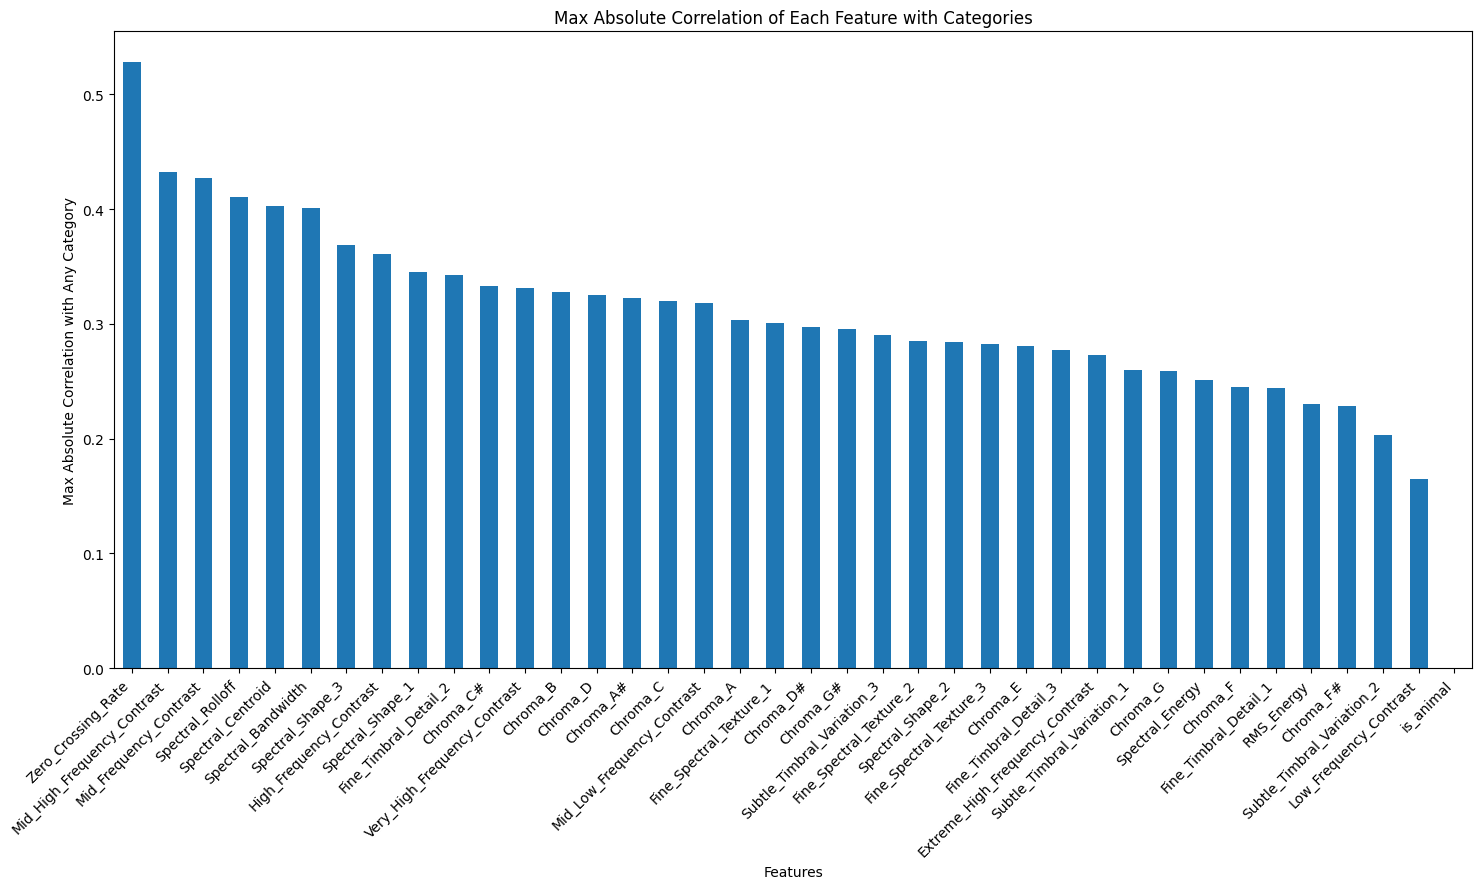

In [53]:

feature_columns = [col for col in animal_metadata_encoded.columns if not col.startswith('category_')]
category_columns = [col for col in animal_metadata_encoded.columns if col.startswith('category_')]

# Now, extract the correlations between features and categories directly
feature_to_category_corr = correlations.loc[feature_columns, category_columns]

# Calculate the maximum absolute correlation for each feature
max_abs_corr_per_feature = feature_to_category_corr.abs().max(axis=1)

# Plotting a bar plot for the summary statistic of each feature
plt.figure(figsize=(15, 9))
max_abs_corr_per_feature.sort_values(ascending=False).plot(kind='bar')
plt.title('Max Absolute Correlation of Each Feature with Categories')
plt.ylabel('Max Absolute Correlation with Any Category')
plt.xlabel('Features')
plt.xticks(rotation=45, ha="right")  # Rotate feature names for better readability
plt.tight_layout()
plt.show()


# Mean Absoulte Correlation Per Feature

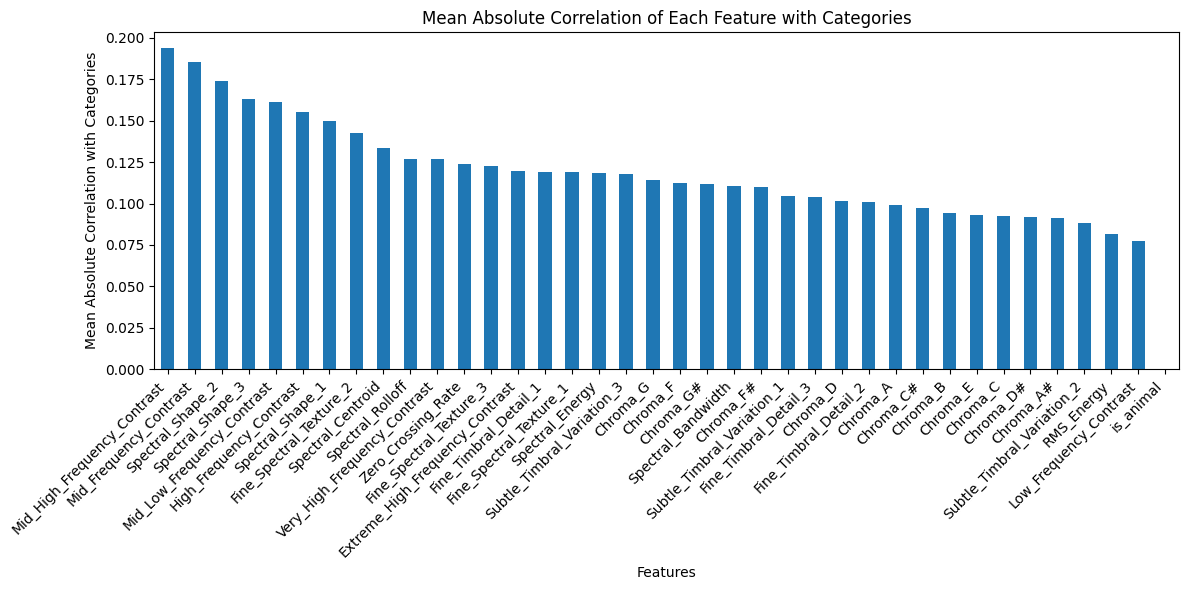

In [54]:
mean_abs_corr_per_feature = feature_to_category_corr.abs().mean(axis=1)

# Plotting a bar plot for the mean absolute correlation of each feature with categories
plt.figure(figsize=(12, 6))
mean_abs_corr_per_feature.sort_values(ascending=False).plot(kind='bar')
plt.title('Mean Absolute Correlation of Each Feature with Categories')
plt.ylabel('Mean Absolute Correlation with Categories')
plt.xlabel('Features')
plt.xticks(rotation=45, ha="right")  # Rotate feature names for better readability
plt.tight_layout()
plt.show()

In [55]:
important_features_final = ['Mid_High_Frequency_Contrast', 'Spectral_Shape_3', 'Mid_Frequency_Contrast',
                            'High_Frequency_Contrast', 'Mid_Low_Frequency_Contrast', 'Spectral_Shape_1',
                            'Fine_Spectral_Texture_2', 'Spectral_Rolloff', 'Spectral_Bandwidth',
                            'Fine_Timbral_Detail_2', 'Spectral_Shape_2', 'Fine_Spectral_Texture_3',
                            'Zero_Crossing_Rate', 'Spectral_Centroid', 'Extreme_High_Frequency_Contrast']

## Conclusion from correlation analysis

category_cat: Mid_High_Frequency_Contrast, Mid_Frequency_Contrast, High_Frequency_Contrast, Spectral_Energy, Spectral_Shape_1

category_rooster: Mid_Frequency_Contrast, High_Frequency_Contrast, Mid_High_Frequency_Contrast, Very_High_Frequency_Contrast, Spectral_Shape_1,     Chroma_C#, Chroma_B, Chroma_D, Chroma_A#, Chroma_C - JUSTIFY NOT INCLUDING SO MANY FEATURES

category_pig: Spectral_Shape_3, Specral_Energy, High_Frequency_Contrast, Mid_High_Frequency_Contrast, Mid_Frequency_Contrast

category_hen: Mid_High_Frequency_Contrast, Fine_Timbral_Detail_1, Fine_Spectral_Texture_2, Fine_Spectral_Texture_1

category_insects: Spectral_Rolloff, Spectral_Bandwidth, High_Frequency_Contrast, Subtle_Timbral_Vibration_3, High_Frequency_Contrast, Subtle_Timbral_Variation_1

category_cow: Mid_Low_Frequency_Contrast, RMS_Energy, Spectral_Shape_1

category_frog: Fine_Timbral_Detail_2, Fine_Spectral_Texture_1, Fine_Spectral_Texture_2, Fine_Timbral_Detail_3, Spectral_Shape_2, Specral_Shape_3, Mid_Frequency_Contrast

category_sheep: Spectral_Shape_1, Spectral_Texture_3

category_crow: Fine_Spectral_Texture_3, Chroma_F#, Fine_Spectral_Texture_2, Spectral_Shape_2

category_chirping_birds: Zero_Crossing_Rate, Spectral_Centroid, Spectral_Shape_3, Mid_High_Frequency_Contrast

category_dog: Spectral_Shape_2, Extreme_High_Frequency_Contrast

Mid_High_Frequency_Contrast: It has a strong correlation with 6 animals
Spectral_Shape_3: Although it only has a strong correlation with 2 animals, its correlation with chirping birds is very high (0.37) and it is the audio feature with the strongest correlation to pig (0.26)
Mid_Frequency_Contrast: It has a strong correlation with 4 animals and high correlation with rooster (0.43)
High_Frequency_Contrast: It has a strong correlation with 5 animals and high correlation with rooster (0.36)
Mid_Low_Frequency_Contrast: Although the only animal it is strongly correlated to is cows, it has the strongest correlation with cows as compared to other audio features for cow and the correlation between other audio features and cow are relatively low
Spectral_Shape_1: It has a strong correlation with 4 animals and the audio feature that has the strongest correlation with sheep is 'Spectral_Shape_1'
- Fine_Spectral_Texture_2: Although it only has a strong correlation with 3 animals, it is the audio feature that has the strongest correlation with hens
Spectral_Rolloff: Although the only animal it is strongly correlated to with is insects, it is the audio feature that has the strongest correlation with insects and the correlation coefficient is very high it is 0.41
Spectral_Bandwidth: Although the only animal it is strongly correlated to with is insects, it has a very strong correlation with insects, 0.4
Fine_Timbral_Detail_2: Although the only animal it is strongly correlared to is frogs, it is the audio feature that has the strongest correlation with frogs, 0.34
- Spectral_Shape_2: Although it is only strongly correlated to 3 animals (frog, crow and dog), it is the the audio feature with the strongest/2nd strongest correlation with crow and dog
Fine_Spectral_Texture_3: Although it is only strongly correlated to 1 animal which is crow, it is the audio feature with the strongest correlation to crow, together with 'Spectral_Shape_2'
Zero_Crossing_Rate: Although it is only strong correlated to 1 animal which is chirping_birds, it is the audio feature with the strongest correlation to chirping_birds and its correlation with chirping_birds is also extremely high,0.53
Spectral_Centroid: Although it is only strong correlated to 1 animal which is chirping_birds, it is the audio feature with the strongest correlation to chirping_birds and its correlation with chirping_birds is also extremely high,0.4
- Extreme_High_Frequency_Contrast: Although it is only strongly correlated to 1 animal which is dog, it is the audio feature with the strongest correlation to dogs, -0.27



# Modelling (with outliers)

In [56]:
X = animal_metadata[important_features_final]  # Feature matrix
y = animal_metadata['category']  # Original labels

# Initialize and fit the label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Transform labels to numerical values

# Correctly split the data into training and testing sets using encoded labels
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=92)

In [57]:
model_accuracies = []

In [58]:
def predict_with_xgb(X_train, y_train, X_test, y_test):
    # Initialize the XGBoost classifier
    model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)

    # Train the model using encoded labels
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy using the encoded test labels
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies.append(('XgBoost', accuracy))
    print(f"Accuracy: {accuracy * 100:.2f}%")

predict_with_xgb(X_train,y_train_encoded,X_test,y_test_encoded)

Accuracy: 97.35%


In [59]:
def predict_with_random_forest_classifier(X_train, y_train, X_test, y_test):
    # Initialize the Random Forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model using encoded labels
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy using the encoded test labels
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies.append(('RandomForestClassifier', accuracy))
    print(f"Accuracy: {accuracy * 100:.2f}%")

predict_with_random_forest_classifier(X_train,y_train_encoded,X_test,y_test_encoded)

Accuracy: 97.35%


In [60]:
def predict_with_svc(X_train, y_train, X_test, y_test):

    # Initialize the SVM classifier
    model = SVC(kernel='rbf', C=1.0, random_state=42)

    # Train the model using encoded labels
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy using the encoded test labels
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies.append(('SVC', accuracy))
    print(f"Accuracy: {accuracy * 100:.2f}%")

predict_with_svc(X_train,y_train_encoded,X_test,y_test_encoded)

Accuracy: 31.82%


In [61]:
def predict_with_k_neighbours_classifier(X_train, y_train, X_test, y_test):
    model = KNeighborsClassifier(n_neighbors=5)

    # Train the model using encoded labels
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy using the encoded test labels
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies.append(('KNeighborsClassifier', accuracy))
    print(f"Accuracy: {accuracy * 100:.2f}%")

predict_with_k_neighbours_classifier(X_train,y_train_encoded,X_test,y_test_encoded)

Accuracy: 49.24%


In [62]:
def predict_with_logistic_regression(X_train, y_train, X_test, y_test):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies.append(('LogisticRegression', accuracy))
    print(f"Accuracy: {accuracy * 100:.2f}%")

predict_with_logistic_regression(X_train, y_train_encoded, X_test, y_test_encoded)

Accuracy: 43.18%


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [63]:
def predict_with_mlp(X_train, y_train, X_test, y_test):
    model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies.append(('NeuralNetwork', accuracy))
    print(f"Accuracy: {accuracy * 100:.2f}%")

predict_with_mlp(X_train, y_train_encoded, X_test, y_test_encoded)

Accuracy: 43.18%


In [64]:
def predict_with_decision_tree(X_train, y_train, X_test, y_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies.append(('DescisionTreeClassifier', accuracy))
    print(f"Accuracy: {accuracy * 100:.2f}%")

predict_with_decision_tree(X_train, y_train_encoded, X_test, y_test_encoded)

Accuracy: 90.53%


In [65]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def predict_with_bagging(X_train, y_train, X_test, y_test):
    base_estimator = DecisionTreeClassifier()
    model = BaggingClassifier(base_estimator, n_estimators=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies.append(('BaggingClassifier', accuracy))
    print(f"Accuracy: {accuracy * 100:.2f}%")

predict_with_bagging(X_train, y_train_encoded, X_test, y_test_encoded)

Accuracy: 96.97%


In [66]:
def predict_with_gaussian_nb(X_train, y_train, X_test, y_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies.append(('Gaussian Naive Bayes', accuracy))
    print(f"Accuracy: {accuracy * 100:.2f}%")

predict_with_gaussian_nb(X_train, y_train_encoded, X_test, y_test_encoded)

Accuracy: 59.47%


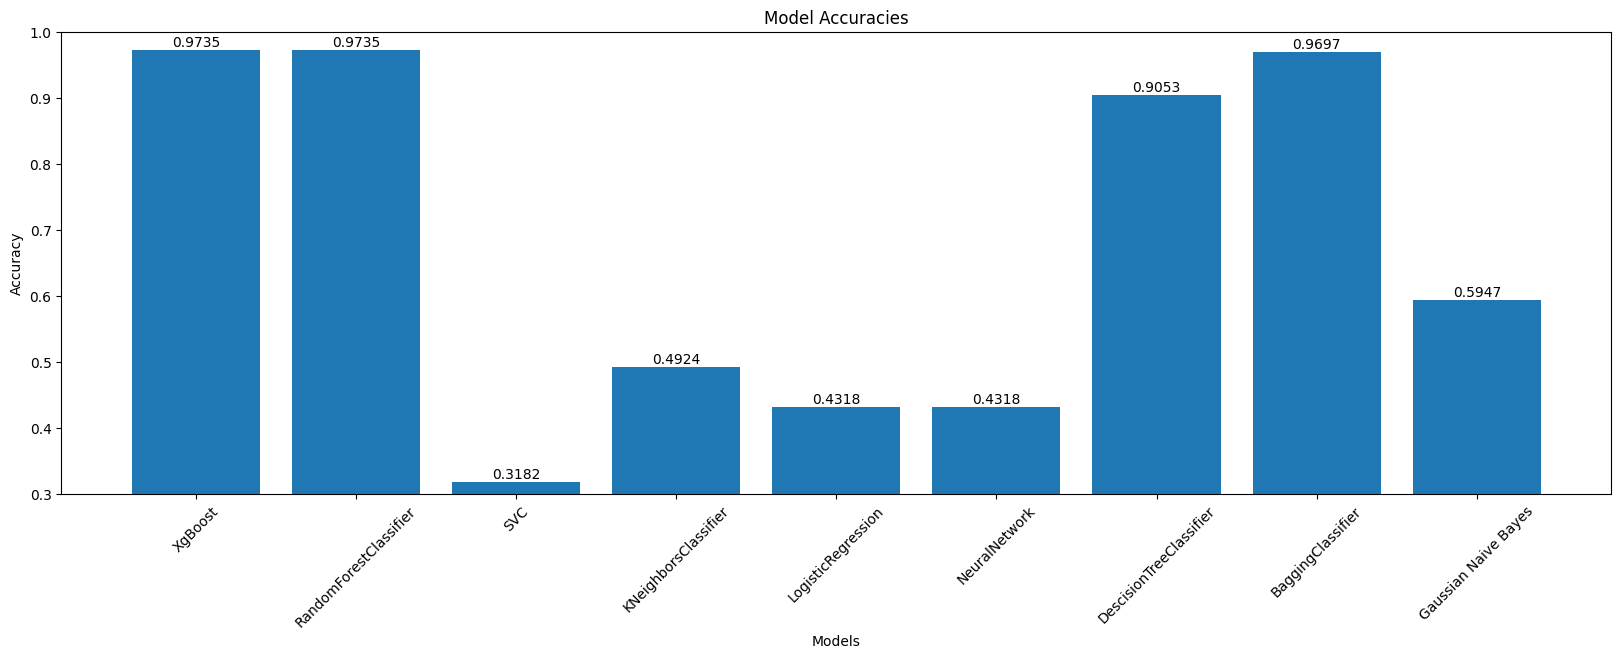

In [67]:
# Assuming model_accuracies is defined somewhere in your code
models, accuracies = zip(*model_accuracies)

# Bar graph
plt.figure(figsize=(20, 6))
bars = plt.bar(models, accuracies)  # Store the bars to use in the loop
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.xticks(rotation=45)
plt.ylim(0.3, 1)  # Set the y-axis limits to [0, 1]

# Adding text labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}',  # format to four decimal places
             verticalalignment='bottom',  # makes it center above the bar
             horizontalalignment='center')

plt.show()


We can observe the best models that we have identified are:
- XgBoost
- RandomForestClassifier
- DescisionTreeClassifier
- BaggingClassifier

# Removing Outliers
In an effort to improve the accuracy of our models, we will be attempting to remove outliers to relevant features. It is important to note that for audio data there may be features where we should not remove outliers. Hence we will be explaining why we removed or did not remove outliers for each feature we identified as important earlier.

## Boxplot analysis of Mid_High_Frequency_Contrast
This feature quantifies how much energy is present in the mid-frequency range compared to the high-frequency range. It's useful for detecting sounds with sharp transitions or edges in these frequency ranges. For example, it might help in identifying the chirping of birds.


### Retaining Outliers
There is a large amount of outliers which indicated significant variations in the data. Some animal species may produce vocalizations with unique frequency characteristics that result in higher or lower value of 'Mid_High_Frequency_Contrast'. Even within the same animal category, there can be significant variability in vocalizations due to factors like age, gender or health status among animals. Outliers may emerge from extreme vocalizations that deviate from the average characteristics of the category.

Although it is true that retaining the outliers may affect the accuracy of our model, we have decided to retain the outliers as we believe they represent genuine variations in the audio data and hold significant information relevant to distinguishing between different animals.

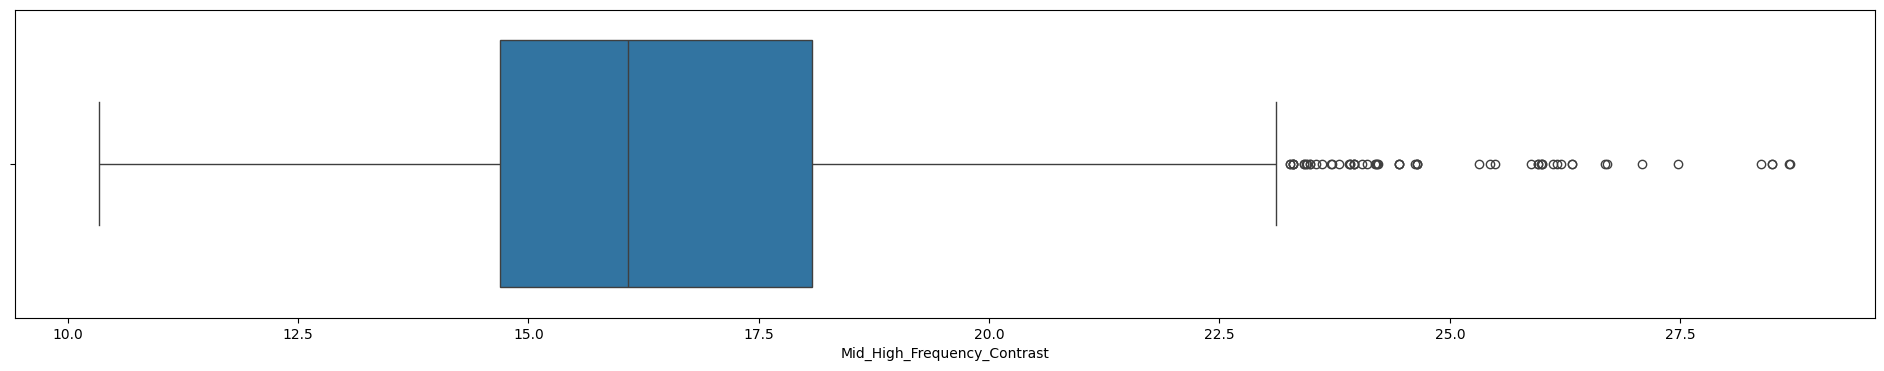

In [68]:
# Assuming 'animal_metadata' is your DataFrame and it contains a 'Mid_High_Frequency_Contrast' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata['Mid_High_Frequency_Contrast'], orient="h")
plt.show()


# Boxplot analysis of Spectral_Shape_3
This feature provides insights into the overall shape of the frequency spectrum of the audio signal. While there may be various ways to calculate spectral shape features, Spectral_Shape_3 likely focuses on a specific parameterization or calculation method. It could reveal patterns in the distribution of frequencies, which might help differentiate between different types of animal calls or environmental sounds.

For example, if animal has strong correlation with Spectral_Shape_3, that animal produces sounds with distinct spectral shapes that differ from other animals or background noise present in the audio recordings. 

For example, dogs may have specific patterns in their barking or howling that manifest as unique shapes in the frequency spectrum, which can be captured by the feature "Spectral_Shape_3"

### Retaining Outliers

Outliers in 'Spectral_Shape_3' could arise from genuine variations in the spectral shape characteristics pf the audio data. Certain animal sounds may exhibit unique spectral properties that result in extreme values for this feature. Outliers in 'Spectral_Shape_3' may contain valuable information about rare or distinctive audio patterns that distinguish certain animal categories. They could represent unique vocalizations or unusual sound features specific to particular species. Therefore, we have decided to retain the outliers.



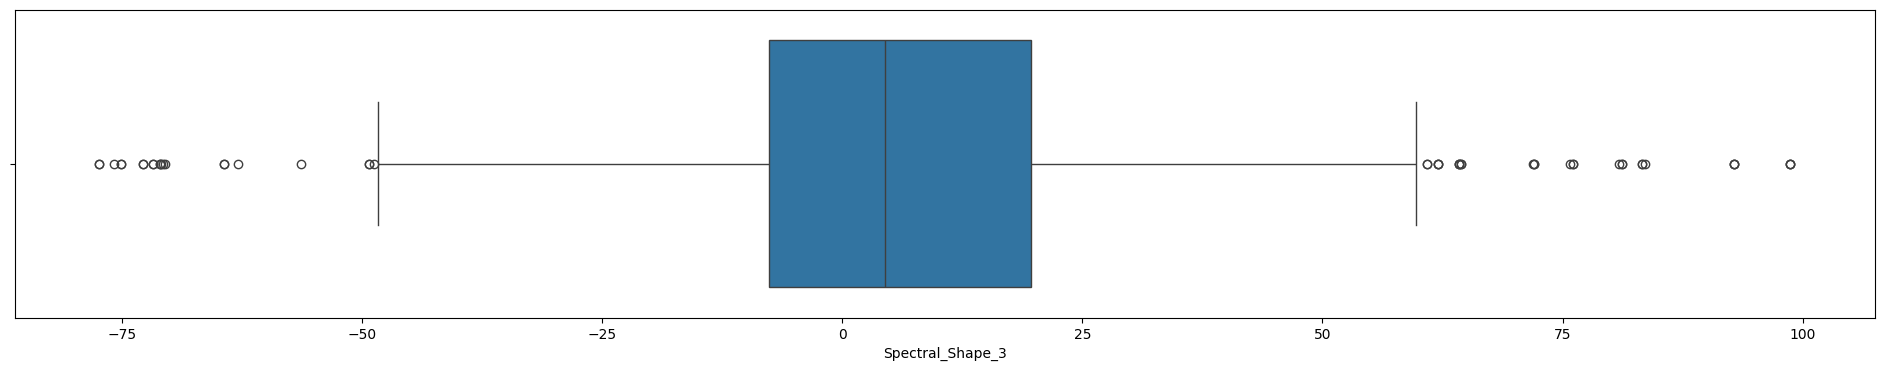

In [69]:
# Assuming 'animal_metadata' is your DataFrame and it contains a 'Spectral_Shape_3' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata['Spectral_Shape_3'], orient="h")
plt.show()

# Boxplot analysis of Mid_Frequency_Contrast

Similar to Mid_High_Frequency_Contrast, but specifically targeting the mid-frequency range. This feature helps in understanding how energy is distributed within this particular frequency band, which could be crucial for discerning sounds that are dominant in mid-frequency content, such as certain animal vocalizations or machinery noises.

### Retaining Outliers
Different animal species produce vocalizations with varying frequency distributions. Some species may have distinct vocalizations that result in higher or lower mid-frequency contrast compared to others. Outliers may contain valuable information about rare or unique vocalizations that could be important for classifying certain animal categories.

Since the outliers could represent genuine variations in animal vocalizations or contain meaningful information for distingushing betweenn animals, retaining them could enhance the richness of the dataset and we have decided to retain them.
 

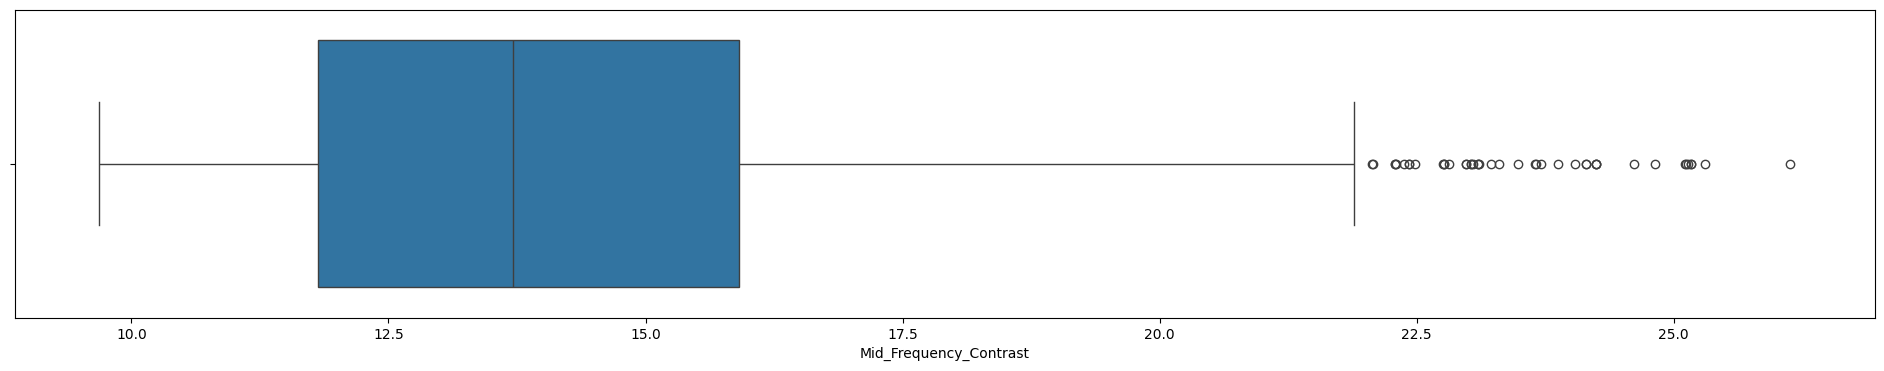

In [70]:
# Assuming 'animal_metadata' is your DataFrame and it contains a 'Mid_Frequency_Contrast' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata['Mid_Frequency_Contrast'], orient="h")
plt.show()

# Boxplot analysis of High_Frequency_Contrast

This feature measures the difference in energy between high frequencies in the audio signal. It's particularly valuable for detecting high-pitched sounds or sharp transients, which might be indicative of certain animal calls, such as bird songs or insect sounds.

### Retaining Outliers
Some animal categories might naturally produce audio recordings with higher or lower high-frequency contrast compared to others. For instance, birds or insects with distinctive calls might exhibit higher high-frequency contrast compared to mammals like cows or sheep. The outliers might represent unique audio samples that contain valuable information for distinguishing between certain animal categories which improves the accuracy of animal classification. We have hence decided to retain the outliers.


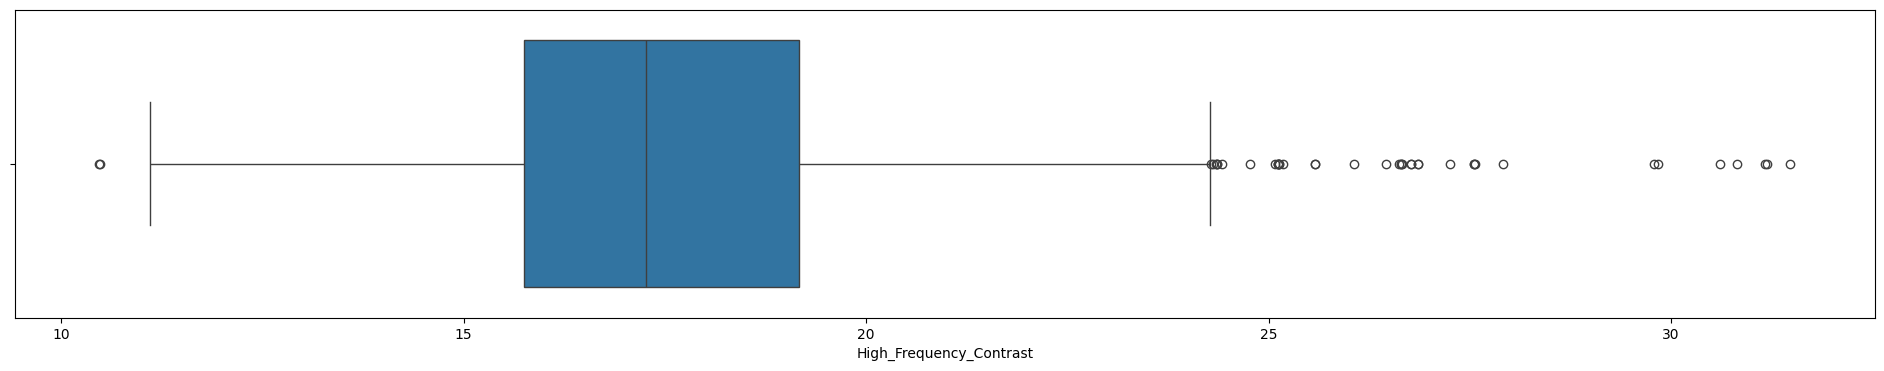

In [71]:
# Assuming 'animal_metadata' is your DataFrame and it contains a 'High_Frequency_Contrast' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata['High_Frequency_Contrast'], orient="h")
plt.show()

# Boxplot analysis of Mid_Low_Frequency_Contrast

Similar to Mid_High_Frequency_Contrast, but focusing on the mid-low frequency range. This feature helps in analyzing the energy distribution within this frequency band, which could be relevant for identifying sounds like distant animal growls or low-frequency environmental noises.\

### Removing Outliers
Outliers in 'Mid_Low_Frequency_Contrast' could be due to certain animal species producing vocalizations with unique frequency characteristics. Outliers could represent rare but valid instances of animal vocalizations with distinct frequency patterns, providing valuable insights into the diversity of the dataset. 

Therefore, we have decided to retain the outliers.

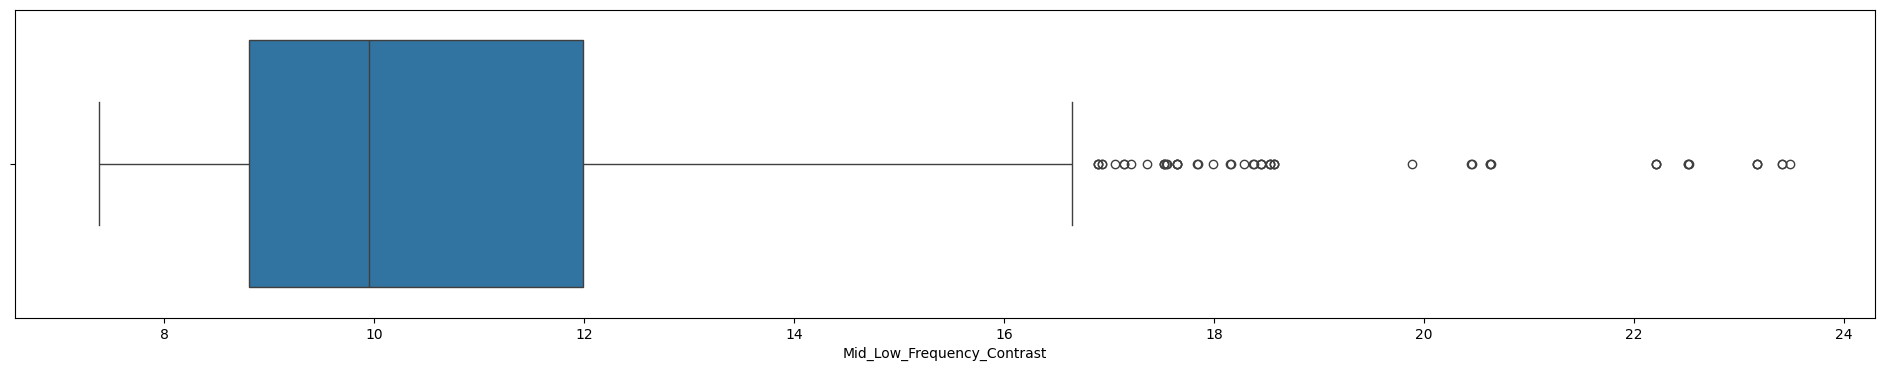

In [72]:
# Assuming 'animal_metadata' is your DataFrame and it contains a 'High_Frequency_Contrast' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata['Mid_Low_Frequency_Contrast'], orient="h")
plt.show()

# Boxplot analysis of Spectral_Shape_1

Another descriptor of the spectral shape, likely employing a different approach than Spectral_Shape_3. This feature might capture different aspects of the frequency spectrum's shape, providing complementary information for sound analysis and classification.

### Removing Outliers
 Outliers in the 'Spectral_Shape_1' feature may indicate extreme values that deviate significantly from the typical spectral shape patterns observed in the majority of the audio samples. These outliers could arise due to various reasons, including recording artifacts, anomalies in the audio files, or genuine variations in the spectral characteristics of different animal sounds.

 In a well-controlled experimental setting or data collection process, most data points should follow a similar pattern or distribution, with only minor variations. Therefore, if there are only a few outliers, it suggests that they deviate significantly from the expected patterns observed in the majority of the data, which could be indicative of errors.

 Furthermore, since there are only a few outliers present in the dataset, removing them is unlikely to significantly skew the overall distribution or characteristics of the data. 

 Therefore, we have decided to remove the outliers so as to improve the quality of our dataset and the robustness of our model.

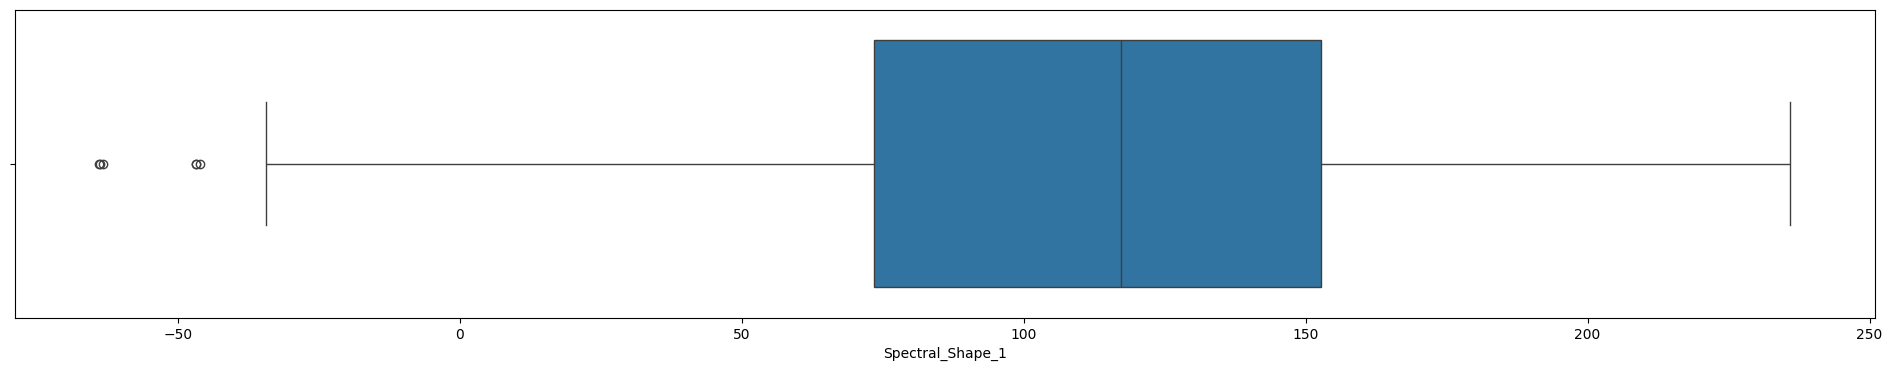

In [73]:
# Assuming 'animal_metadata' is your DataFrame and it contains a 'Spectral_Shape_1' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata['Spectral_Shape_1'], orient="h")
plt.show()

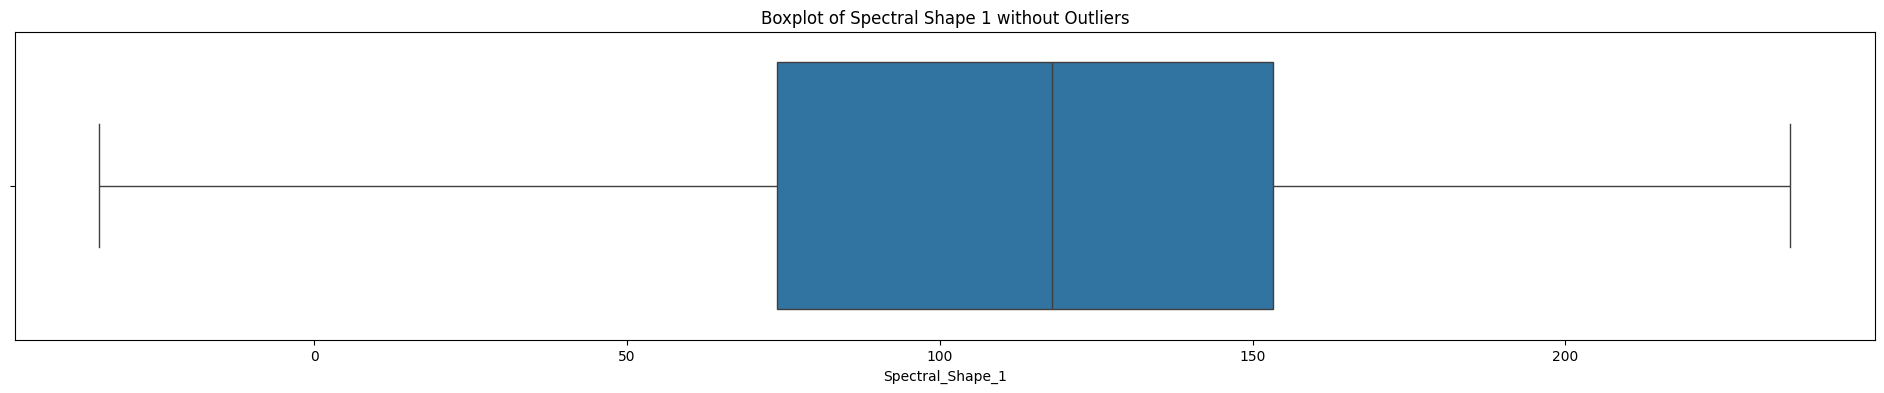

In [74]:
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = animal_metadata['Spectral_Shape_1'].quantile(0.25)
Q3 = animal_metadata['Spectral_Shape_1'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
animal_metadata_cleaned = animal_metadata[(animal_metadata['Spectral_Shape_1'] >= lower_bound) & (animal_metadata['Spectral_Shape_1'] <= upper_bound)]

# Plot the boxplot without outliers
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata_cleaned['Spectral_Shape_1'], orient="h")
plt.title('Boxplot of Spectral Shape 1 without Outliers')
plt.show()

# Boxplot analysis of Spectral_Rolloff

Spectral rolloff represents the frequency below which a certain percentage of the total spectral energy lies, indicating the distribution of energy in the frequency spectrum. A high correlation with spectral rolloff suggests that the phenomenon under study exhibits spectral characteristics aligned with the concentration of energy at certain frequencies, as represented by the spectral rolloff value.

For instance, if "is_birdsong" has a high correlation with spectral rolloff, it suggests that bird songs tend to exhibit distinct spectral characteristics where a significant portion of the energy is concentrated at lower frequencies.

A high spectral rolloff value suggests that most of the spectral energy is concentrated at lower frequencies, while a low value indicates that energy extends to higher frequencies. In audio signals, high-frequency components often contribute to the perceived brightness or treble of the sound.

### Retaining Outliers
Different animal species produce vocalizations with distinct frequency characteristics. Outliers in 'Spectral_Rolloff' could arise from rare or unique vocalizations that deviate significantly from the typical patterns observed in common animal sounds. For example, a particularly high or low 'Spectral_Rolloff' value might indicate an unusual vocalization specific to certain species within your dataset.

Outliers in 'Spectral_Rolloff' might contain valuable information about rare or unique animal vocalizations that could enhance the classification model's ability to distinguish between different species. Therefore, we have decided to retain the outliers.

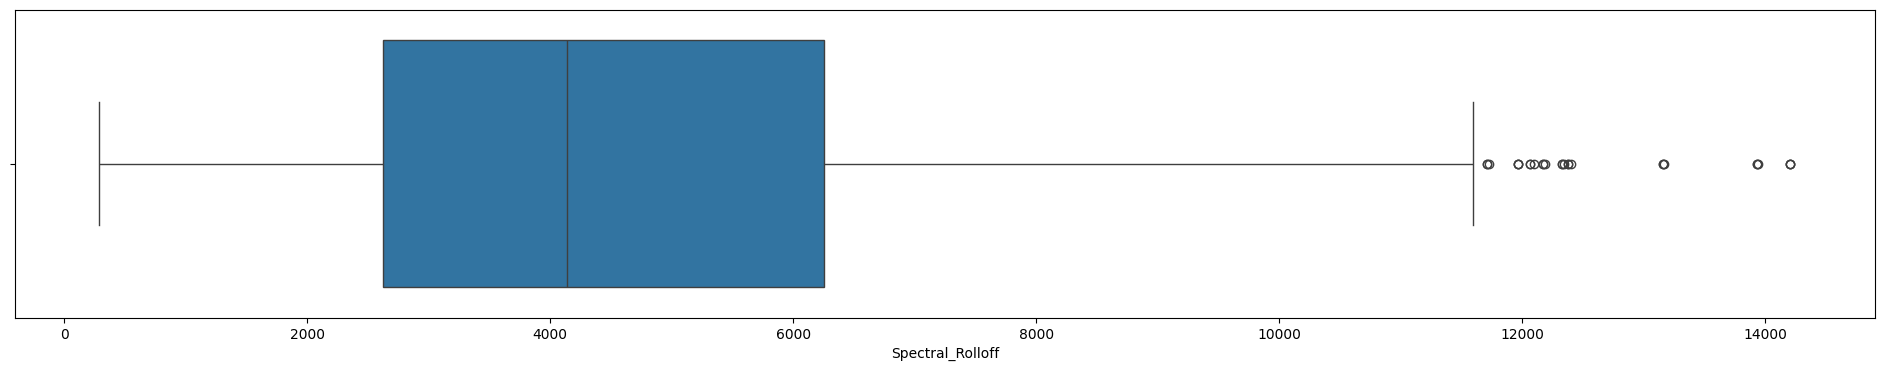

In [75]:
# Assuming 'animal_metadata' is your DataFrame and it contains a 'Spectral_Rolloff' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata['Spectral_Rolloff'], orient="h")
plt.show()

# Boxplot analysis of Spectral_Bandwidth

This feature measures the width of the frequency range that contains a certain percentage of the total spectral energy. It reveals how spread out the energy is across frequencies, which is useful for distinguishing between sounds with different spectral distributions. For instance, it might help differentiate between narrowband sounds like whistles and broadband sounds like animal vocalizations.

### Removing Outliers
Since there is only one single outlier, it is highly likely that it is due to an error rather than a genuine representation of unique variation for a certain animal. 

Allowing a single outlier to remain in the dataset can skew statistical analyses and model predictions by disproportionately influencing calculations of central tendency and variability. It can lead to inaccurate conclusions and misinterpretations of the data's true characteristics.

Furthermore, since there is only a single outlier present in the dataset, removing it is unlikely to significantly skew the overall distribution or characteristics of the data. 

Therefore, we have decided to remove the outlier so as to improve the accuracy of our model.

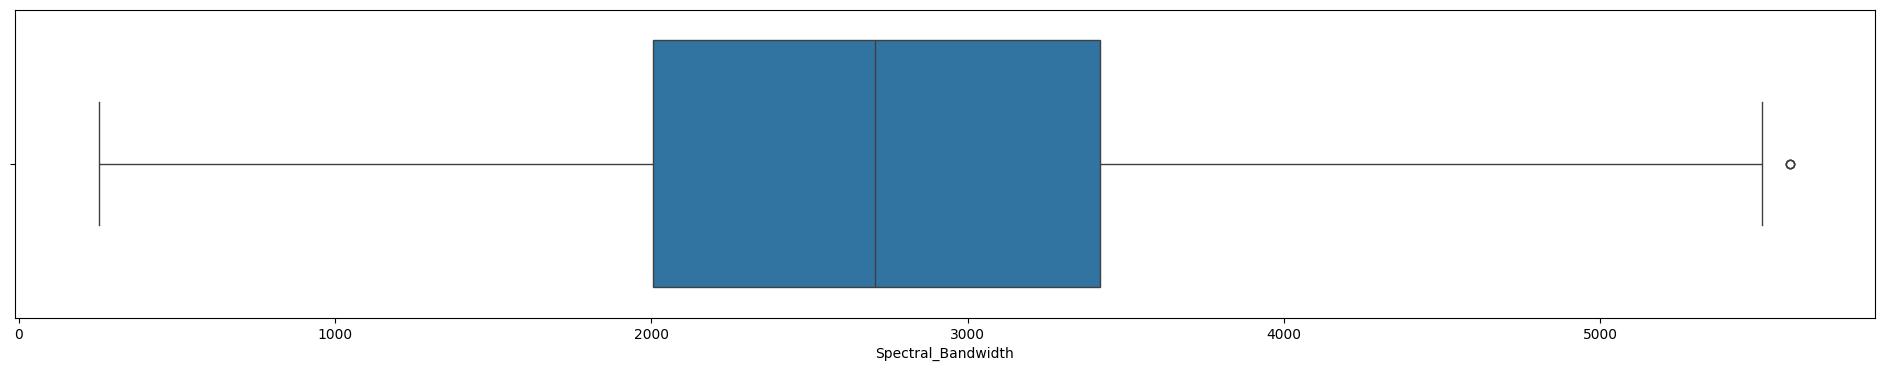

In [76]:
# Assuming 'animal_metadata' is your DataFrame and it contains a 'Spectral_Bandwidth' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata['Spectral_Bandwidth'], orient="h")
plt.show()

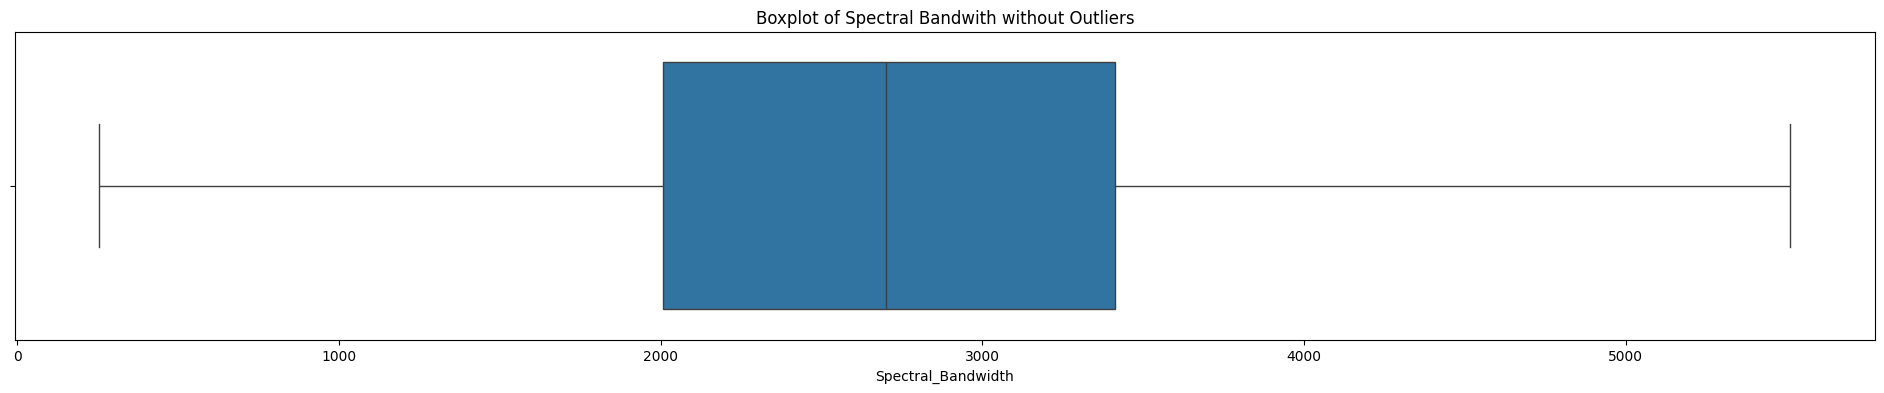

In [77]:
# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = animal_metadata['Spectral_Bandwidth'].quantile(0.25)
Q3 = animal_metadata['Spectral_Bandwidth'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
animal_metadata_cleaned = animal_metadata_cleaned[(animal_metadata_cleaned['Spectral_Bandwidth'] >= lower_bound) & (animal_metadata_cleaned['Spectral_Bandwidth'] <= upper_bound)]

# Plot the boxplot without outliers
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata_cleaned['Spectral_Bandwidth'], orient="h")
plt.title('Boxplot of Spectral Bandwith without Outliers')
plt.show()

# Boxplot analysis of Fine_Timbral_Detail_2

This feature captures subtle variations or nuances in the timbre of the sound. It likely focuses on detailed features related to texture or tonal quality, which can be crucial for discriminating between similar sounds or detecting variations within the same sound category, such as different bird species or individual animal calls.

In essence, a high correlation with Fine_Timbral_Detail_2 indicates that the phenomenon being studied exhibits timbral characteristics that are well-captured by the nuanced features encapsulated in Fine_Timbral_Detail_2. This information can be valuable for tasks such as sound classification, where distinguishing between different sound sources or categories relies heavily on their unique timbral qualities.


### Retaining Outliers
Animal vocalizations exhibit inherent variability, even within the same species. Outliers may represent unique vocalizations with distinct timbral characteristics that deviate from the typical patterns observed in the majority of samples.

Furthermore, there is a large number of outliers that fall outside the standard deviation. The presence of numerous outliers suggests that they may represent genuine variations in the dataset rather than mere errors or anomalies. Removing all outliers could result in a loss of valuable information and potentially distort the true distribution of timbral detail within the dataset. Each outlier might correspond to a unique vocalization or acoustic characteristic that contributes to the diversity of the dataset. 

Therefore, we have decided to retain the outliers.

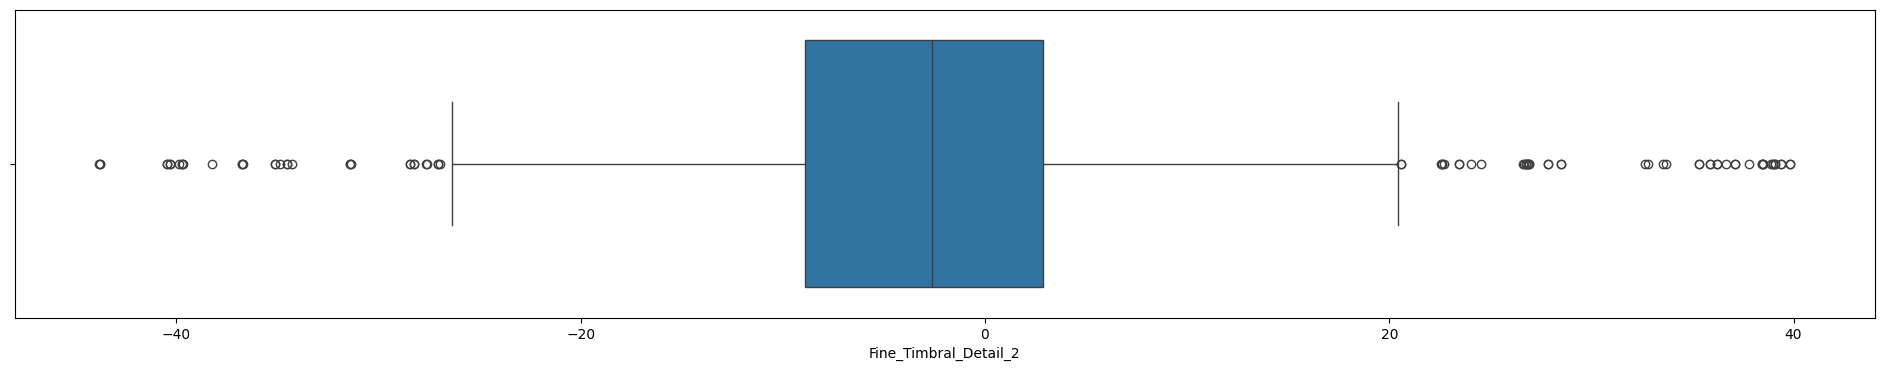

In [78]:
# Assuming 'animal_metadata' is your DataFrame and it contains a 'Fine_Timbral_Detail_2' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata['Fine_Timbral_Detail_2'], orient="h")
plt.show()

# Boxplot analysis of Fine_Spectral_Texture_3

Similar to Fine_Timbral_Detail_2, but specifically targeting spectral texture features. This feature aims to capture finer details in the frequency content of the sound, which could be relevant for identifying subtle spectral patterns or distinguishing between sounds with similar timbral characteristics but different spectral textures.

### Retaining Outliers
'Fine_Spectral_Texture_3' captures subtle variations in spectral texture, which may include fine details or nuances in the audio signal. Outliers could represent extreme or uncommon variations in these subtle spectral features.

Outliers in 'Fine_Spectral_Texture_3' could contain valuable information about unique spectral characteristics or rare patterns in the audio data. They may represent specific acoustic signatures that contribute to distinguishing between different animal sounds.

Since the outliers in 'Fine_Spectral_Texture_3' represent genuine variations in spectral texture that contribute to the diversity of the dataset, retaining them could enhance the model's ability to capture the full range of acoustic features relevant to animal sound classification. Outliers may provide valuable insights into rare or unique spectral patterns. 

Therefore, we have decided to retain the outliers

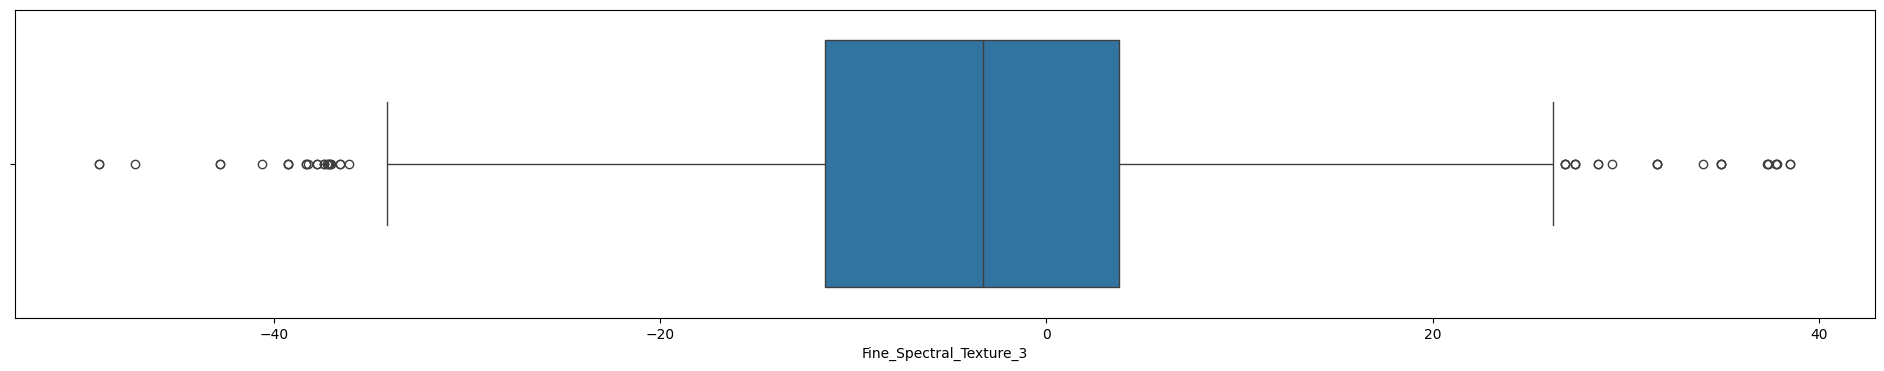

In [79]:
# Assuming 'animal_metadata' is your DataFrame and it contains a 'Fine_Spectral_Texture_3' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata['Fine_Spectral_Texture_3'], orient="h")
plt.show()

# Boxplot analysis of Zero_Crossing_Rate

This feature measures the rate at which the audio signal changes sign, indicating how quickly it crosses the zero amplitude line. It's useful for estimating pitch and detecting percussive sounds, as it reflects the frequency of oscillation or the rhythmic patterns present in the signal. For example, it might help identify the rhythmic chirping of crickets or the repetitive calls of certain bird species.

For example,the rapid chirping or singing of birds often exhibits high zero-crossing rates due to the quick changes in amplitude between individual bird calls. Each chirp or tweet corresponds to a rapid fluctuation in the audio signal, resulting in a high rate of zero crossings.

### Retaining Outliers
The 'Zero_Crossing_Rate' measures the rate at which the audio signal changes its sign, reflecting signal complexity. Outliers may occur when the audio signal contains sudden, rapid changes or irregular patterns, leading to extreme zero-crossing rates.

Outliers in the 'Zero_Crossing_Rate' feature could reflect genuine variations in signal complexity or contribute to the diversity of the dataset, retaining them could enrich the training data and improve model robustness. Outliers that represent distinctive signal characteristics relevant to the classification task should be retained to ensure the model captures the full range of acoustic features. 

Therefore, we have decided to retain the outliers

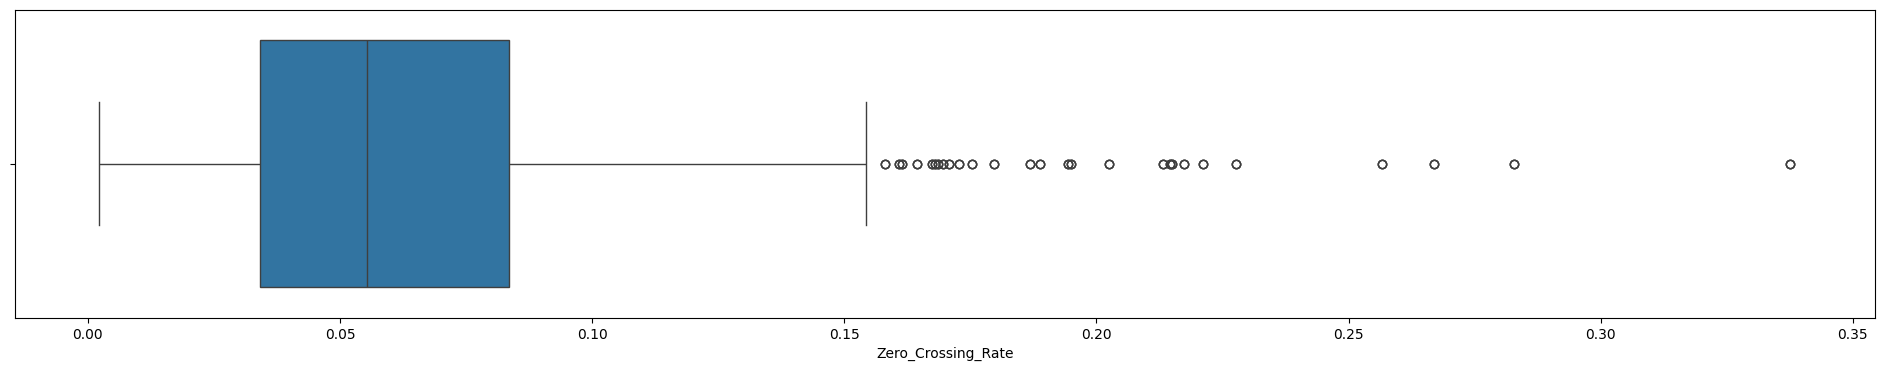

In [80]:
# Assuming 'animal_metadata' is your DataFrame and it contains a 'Zero_Crossing_Rate' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata['Zero_Crossing_Rate'], orient="h")
plt.show()

# Boxplot analysis of Spectral_Centroid

This feature represents the "center of mass" of the frequency distribution, indicating where most of the energy in the spectrum is concentrated. It's often correlated with perceived brightness or pitch in auditory perception. Spectral centroid can provide valuable information about the overall tonal characteristics of the sound, aiding in the classification of animal calls or environmental sounds based on their spectral centroids.

A high correlation with spectral centroid suggests that the distribution of energy in the frequency spectrum, particularly where it's concentrated, is closely tied to the characteristic being studied.

For example, if a certain type of bird call has a high correlation with spectral centroid, it implies that the pitch or perceived brightness of the bird's call is closely related to its species. For example, the high-pitched chirps of a canary might have a distinct spectral centroid compared to the lower, throaty calls of a crow.

### Retaining Outliers
Different animal species produce vocalizations with distinct frequency distributions. Outliers in 'Spectral_Centroid' may represent unique or rare vocalizations that deviate significantly from the typical spectral centroid values observed in the majority of the samples.

Outliers in 'Spectral_Centroid' may contain valuable information about rare or unique animal vocalizations that could be essential for accurately classifying different species or categories. They might represent distinct vocalization types or behaviors that are relevant to specific animal species.

Therefore, we have decided to retain the outliers which may capture unique spectral characteristics associated with specific animal behaviors which are important in distinguishing between animals

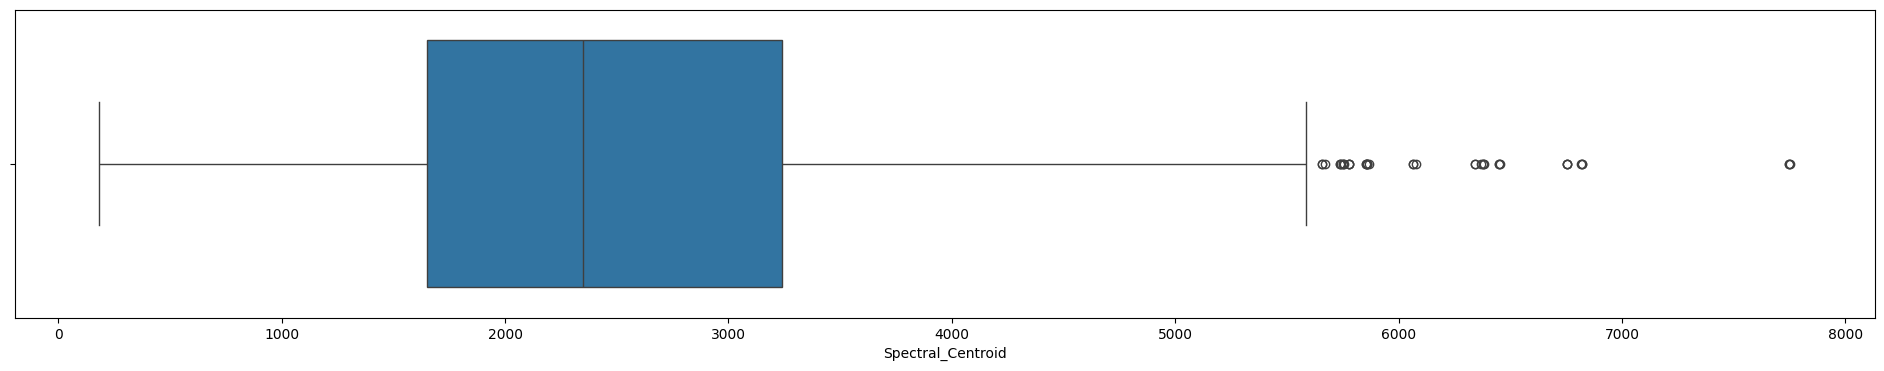

In [81]:
# Assuming 'animal_metadata' is your DataFrame and it contains a 'Spectral_Centroid' column
f = plt.figure(figsize=(24, 4))
sb.boxplot(data=animal_metadata['Spectral_Centroid'], orient="h")
plt.show()

# Modelling
We will only be using the models that performed well in the earlier modelling. The models are as follows
- XgBoost
- RandomForestClassifier
- DescisionTreeClassifier
- BaggingClassifier

In [82]:
X = animal_metadata_cleaned[important_features_final]  # Feature matrix
y = animal_metadata_cleaned['category']  # Original labels

# Initialize and fit the label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Transform labels to numerical values

# Correctly split the data into training and testing sets using encoded labels
X_train_no_outliers, X_test_no_outliers, y_train_encoded_no_outliers, y_test_encoded_no_outliers = train_test_split(X, y_encoded, test_size=0.2, random_state=92)

In [83]:
model_accuracies = [(model + " (with outliers)", accuracy) for model, accuracy in model_accuracies if model in ['XgBoost', 'RandomForestClassifier', 'DescisionTreeClassifier', 'BaggingClassifier']]


In [84]:
predict_with_xgb(X_train_no_outliers, y_train_encoded_no_outliers,X_test_no_outliers,y_test_encoded_no_outliers)

Accuracy: 96.58%


In [85]:
predict_with_decision_tree(X_train_no_outliers, y_train_encoded_no_outliers,X_test_no_outliers,y_test_encoded_no_outliers)

Accuracy: 88.59%


In [86]:
predict_with_bagging(X_train_no_outliers, y_train_encoded_no_outliers,X_test_no_outliers,y_test_encoded_no_outliers)

Accuracy: 97.34%


In [87]:
predict_with_random_forest_classifier(X_train_no_outliers, y_train_encoded_no_outliers,X_test_no_outliers,y_test_encoded_no_outliers)

Accuracy: 97.34%


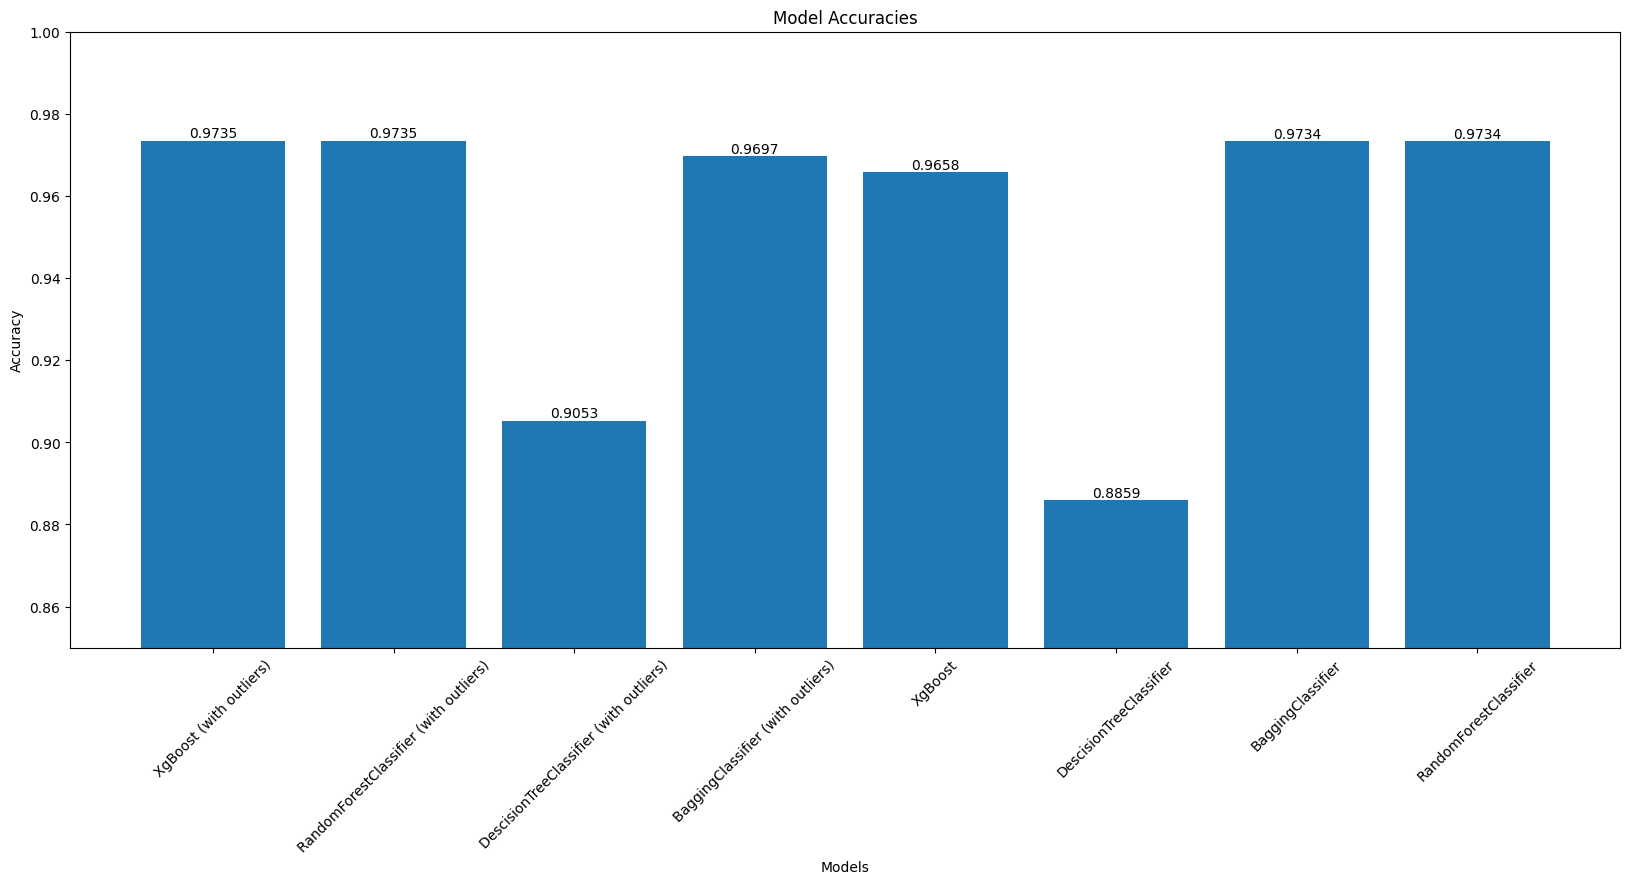

In [88]:
# Assuming model_accuracies is defined somewhere in your code
models, accuracies = zip(*model_accuracies)

# Bar graph
plt.figure(figsize=(20, 8))
bars = plt.bar(models, accuracies)  # Store the bars to use in the loop
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.xticks(rotation=45)
plt.ylim(0.85, 1)  # Set the y-axis limits to [0, 1]

# Adding text labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}',  # format to four decimal places
             verticalalignment='bottom',  # makes it center above the bar
             horizontalalignment='center')

plt.show()


We can observe that the best model is xgboost and randomforestclassifier but with their outliers

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb

def predict_with_random_forest_classifier_tuned(X_train, y_train, X_test, y_test, hyperparams):
    # Initialize the Random Forest classifier with the given hyperparameters
    model = RandomForestClassifier(**hyperparams)
    # Train the model using encoded labels
    model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Calculate the accuracy using the encoded test labels
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

def predict_with_xgb_tuned(X_train, y_train, X_test, y_test, hyperparams):
    # Initialize the XGBoost classifier with the given hyperparameters
    model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False, **hyperparams)
    # Train the model using encoded labels
    model.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Calculate the accuracy using the encoded test labels
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Greedy search for Random Forest Classifier
rf_hyperparams = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_rf_accuracy = 0
best_rf_hyperparams = {}

for n_estimators in rf_hyperparams['n_estimators']:
    for max_depth in rf_hyperparams['max_depth']:
        for min_samples_split in rf_hyperparams['min_samples_split']:
            for min_samples_leaf in rf_hyperparams['min_samples_leaf']:
                hyperparams = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf
                }
                accuracy = predict_with_random_forest_classifier_tuned(X_train, y_train_encoded, X_test, y_test_encoded, hyperparams)
                if accuracy > best_rf_accuracy:
                    best_rf_accuracy = accuracy
                    best_rf_hyperparams = hyperparams

print("Best Random Forest Classifier Hyperparameters:")
print(best_rf_hyperparams)
print(f"Best Random Forest Classifier Accuracy: {best_rf_accuracy * 100:.2f}%")

# Greedy search for XGBoost
xgb_hyperparams = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0]
}

best_xgb_accuracy = 0
best_xgb_hyperparams = {}

for max_depth in xgb_hyperparams['max_depth']:
    for learning_rate in xgb_hyperparams['learning_rate']:
        for n_estimators in xgb_hyperparams['n_estimators']:
            for subsample in xgb_hyperparams['subsample']:
                hyperparams = {
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'n_estimators': n_estimators,
                    'subsample': subsample
                }
                accuracy = predict_with_xgb_tuned(X_train, y_train_encoded, X_test, y_test_encoded, hyperparams)
                if accuracy > best_xgb_accuracy:
                    best_xgb_accuracy = accuracy
                    best_xgb_hyperparams = hyperparams

print("Best XGBoost Hyperparameters:")
print(best_xgb_hyperparams)
print(f"Best XGBoost Accuracy: {best_xgb_accuracy * 100:.2f}%")

Best Random Forest Classifier Hyperparameters:
{'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best Random Forest Classifier Accuracy: 98.11%
Best XGBoost Hyperparameters:
{'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Accuracy: 97.35%
